<h1> Master Code </h1>

<h4> Basic Library </h4>

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set()

# Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from statistics import mean
from regressors import stats
import statsmodels.api as sm
import statsmodels.genmod.families.links as links
from statsmodels.stats.mediation import Mediation


In [2]:
data = pd.read_csv("/Users/ning/Desktop/columbia 2020/Capstone Project/CE_Data_Final_Columbia.csv")

<h3> Data Cleaning </h3> 

In [3]:
cols = ["Q6_BrandSpend_Skincare","Q6_BrandSpend_Hair","Q6_BrandSpend_Beauty",
        "Q7_NUMBER_CategorySpend_Skincare","Q7_NUMBER_CategorySpend_Hair",
        "Q7_NUMBER_CategorySpend_Beauty","Q8_BrandTransactions",
        "Q9_NUMBER_CategoryTransactions","Q14_Brand_Card","Q14_Other_Cards",
        "Q15_Brand_CashAccount","Q15_Other_CashAccounts","Q15b_Brand_Investments",
       "Q15b_Other_Investments","Q15c_Brand_Loans","Q15c_Other_Loans",
        "Q18_Brand_Investments","Q18_Other_Investments","Q27_1_1","Q27_2_1","Q27_3_1","Q27_4_1",
        "Q27b_1_1","Q27b_2_1","Q27b_3_1","Q27b_4_1"
       ]

In [4]:
data[cols] = data[cols].replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric)

In [5]:
def label_cutoff (row):
    ## Q6
    if (row["Q6_BrandSpend_Skincare"]> 300) | (row["Q6_BrandSpend_Hair"] > 300) | (row["Q6_BrandSpend_Beauty"] > 300):
        return 1
    # Exclude the 0 except for those with Spotify
    if (row["Brand"] != 'Spotify') and  (row["Q6_BrandSpend"] == 0):
        return 1
    
    ## Q7
    if (row["Q7_NUMBER_CategorySpend_Skincare"]> 300) | (row["Q7_NUMBER_CategorySpend_Hair"] > 300) | (row["Q7_NUMBER_CategorySpend_Beauty"] > 300):
        return 1
    
    ## Q8
    if (row["Programming_Category"] == 'Airlines' and  row["Q8_BrandTransactions"]>75.6) | (row["Programming_Category"] == 'Apparel' and  row["Q8_BrandTransactions"]>78.3) | (row["Programming_Category"] == 'Big Box Retailers & Drugstores' and  row["Q8_BrandTransactions"]>41.2) | (row["Programming_Category"] == 'Fast Fashion Retailers & Department Stores' and  row["Q8_BrandTransactions"]>25) | (row["Programming_Category"] == 'Food Delivery' and  row["Q8_BrandTransactions"]>20) | (row["Programming_Category"] == 'Hospitality' and  row["Q8_BrandTransactions"]>25) | (row["Programming_Category"] == 'Large Online Retailers' and  row["Q8_BrandTransactions"]>50) | (row["Programming_Category"] == 'QSR' and  row["Q8_BrandTransactions"]>17.48) | (row["Programming_Category"] == 'Ride Sharing' and  row["Q8_BrandTransactions"]>20) | (row["Programming_Category"] == 'Soft Drinks' and  row["Q8_BrandTransactions"]>30):
        return 1

    
    ## Q9
    if (row["Programming_Category"] == 'Airlines' and  row["Q9_NUMBER_CategoryTransactions"]>100) | (row["Programming_Category"] == 'Apparel' and  row["Q9_NUMBER_CategoryTransactions"]>137.25) | (row["Programming_Category"] == 'Big Box Retailers & Drugstores' and  row["Q9_NUMBER_CategoryTransactions"]>100) | (row["Programming_Category"] == 'Fast Fashion Retailers & Department Stores' and  row["Q9_NUMBER_CategoryTransactions"]>80) | (row["Programming_Category"] == 'Food Delivery' and  row["Q9_NUMBER_CategoryTransactions"]>40) | (row["Programming_Category"] == 'Hospitality' and  row["Q9_NUMBER_CategoryTransactions"]>50) | (row["Programming_Category"] == 'Large Online Retailers' and  row["Q9_NUMBER_CategoryTransactions"]>70) | (row["Programming_Category"] == 'QSR' and  row["Q9_NUMBER_CategoryTransactions"]>30) | (row["Programming_Category"] == 'Ride Sharing' and  row["Q9_NUMBER_CategoryTransactions"]>36.8) | (row["Programming_Category"] == 'Soft Drinks' and  row["Q9_NUMBER_CategoryTransactions"]>60):
        return 1
    
    ## Q14
    if (row["Q14_Brand_Card"] > 10000) | (row["Q14_Other_Cards"] > 12540):
        return 1
    
    ## Q15
    if (row["Q15_Brand_CashAccount"] > 250000) | (row["Q15_Other_CashAccounts"] > 900000) | (row["Q15b_Brand_Investments"] > 964000) | (row["Q15b_Other_Investments"] > 2028000) | (row["Q15c_Brand_Loans"] > 621000) | (row["Q15c_Other_Loans"] > 402848.38):
        return 1
    
    ## Q18
    if (row["Q18_Brand_Investments"] > 1700000) | (row["Q18_Other_Investments"] > 2100000):
        return 1
    
    ## Q27
    if (row["Q27_1_1"] > 5) | (row["Q27_2_1"] > 4) | (row["Q27_3_1"] > 4) | (row["Q27_4_1"] > 2) | (row["Q27b_1_1"] > 5) | (row["Q27b_2_1"] > 3) | (row["Q27b_3_1"] > 5) | (row["Q27b_4_1"] > 3):
        return 1
    
    return 0

In [6]:
data['cutoff_label'] = data.apply (lambda row: label_cutoff(row), axis=1)
data = data[data['cutoff_label'] == 0]

In [29]:
# Binomial Logistic Regression Model:
def bi_logistic(df,start,stop):
    X = df.loc[:,start:stop]
    y = df['Satisfaction_tier']
    sample_weight = df['weights']
    clf = LogisticRegression(random_state=0).fit(X, y,sample_weight=sample_weight)
    p_value = stats.coef_pval(clf, X, y)
    coef = []
    for i in range(len(X.columns)):
        coef.append([X.columns[i],clf.coef_[0][i],p_value[i]])
    coef = pd.DataFrame(coef,columns=['Features','Coefficient','p_value'])
    coef = coef.sort_values(by='Coefficient',ascending=False)
    

    return coef

<h2> Customer Engagement --> Brand Satisfaction </h2>

In [146]:
# Feature Engineering for Q73
def feature_engineering_Q73(df):
    df['Driver_Accessibility'] = (df['Q73_1'] + df['Q73_2'] + df['Q73_3'] + df['Q73_4'])/4
    df['Driver_Consistency'] = (df['Q73_5'] + df['Q73_6'] + df['Q73_7'])/3
    df['Driver_Ease of use'] = df['Q73_8']
    df['Driver_Empathy'] = (df['Q73_9'] + df['Q73_10'] + df['Q73_11'])/3
    df['Driver_Latest & Greatest'] = (df['Q73_12'] + df['Q73_12'])/2
    df['Driver_Leadership'] = (df['Q73_14'] + df['Q73_15'])/2
    df['Driver_Memorable & Nostalgia'] = df['Q73_16']
    df['Driver_Personalization'] = (df['Q73_17'] + df['Q73_18'] + df['Q73_19'] 
                                    + df['Q73_20'] + df['Q73_21'] + df['Q73_22'])/6

    df['Driver_Price'] = df['Q73_23']
    df['Driver_Product/Service Quality'] = (df['Q73_24'] + df['Q73_25'])/2
    df['Driver_Data & Security'] = (df['Q73_26'] + df['Q73_27'])/2

    df['Driver_Self-Expression'] = (df['Q73_28'] + df['Q73_29'])/2
    df['Driver_Social Proof'] =(df['Q73_30'] + df['Q73_31'])/2
    df['Driver_Social Responsibility'] = (df['Q73_32'] + df['Q73_33'])/2
    df['Driver_Trust/Authenticity'] = (df['Q73_34'] + df['Q73_34'])/2
    df['Driver_Value'] = (df['Q73_36'] + df['Q73_36'])/2
    df['Driver_Information'] = df['Q73_38']
    df['Driver_Category Impact'] = df['Q73_39']
    
    df = df[['weights'] + list(df.loc[:,'Satisfaction_tier':])].set_index(['weights'])
    return df

In [144]:
def customer_engagement_driver(df,high,low,neutral,outcome):
    df = data[['weights',outcome] + list(data.loc[:,'Q73_1':'Q73_40'])].set_index(['weights'])
    df = df[df[outcome] != ' ']
    df.loc[:,'Q73_1':'Q73_40'] = df.loc[:,'Q73_1':'Q73_40'].replace(' ', np.nan)
    df = df.apply(pd.to_numeric)
    df = df[(df['Q73_40']==2)]#  filter with the straight liner test
    
    df = df[(df[outcome]!=neutral)] 
    df.loc[df[outcome]>=high, 'Satisfaction_tier'] = 1
    df.loc[df[outcome]<=low, 'Satisfaction_tier'] = 0
    df = df.drop(columns=[outcome])
    df.reset_index(inplace=True)
    
    imputer = KNNImputer(n_neighbors=2)  # This could be one parameters to select
    df.loc[:,"Q73_1":"Q73_40"] = imputer.fit_transform(df.loc[:,"Q73_1":"Q73_40"])
    df = feature_engineering_Q73(df)
    df.reset_index(inplace=True)
    
    return df

<h3> Mediation Effect: could be a future step </h3>

In [225]:
def mediation(df,high,low,neutral,outcome):
    df = data[['weights',outcome,'Q67'] + list(data.loc[:,'Q73_1':'Q73_40'])].set_index(['weights'])
    df = df[df[outcome] != ' ']
    df.loc[:,'Q67':'Q73_40'] = df.loc[:,'Q67':'Q73_40'].replace(' ', np.nan)
    df = df.apply(pd.to_numeric)
    df = df[(df['Q73_40']==2)]#  filter with the straight liner test
    df = df[(df[outcome]!=neutral)] 
    df.loc[df[outcome]>=high, 'Satisfaction_tier'] = 1
    df.loc[df[outcome]<=low, 'Satisfaction_tier'] = 0
    df = df.drop(columns=[outcome])
    df.reset_index(inplace=True)
    
    imputer = KNNImputer(n_neighbors=2)  # This could be one parameters to select
    df.loc[:,"Q67":"Q73_40"] = imputer.fit_transform(df.loc[:,"Q67":"Q73_40"])
    df['Brand_Satisfaction'] = df['Q67']
    df = feature_engineering_Q73(df)
    df.reset_index(inplace=True)
    
    return df

In [227]:
def mediation_model(df):
    probit = links.probit
    outcome_model = sm.GLM.from_formula("Satisfaction_tier ~ Brand_Satisfaction + Driver_Consistency",
                                   df, family=sm.families.Binomial(link=probit()))
    mediator_model = sm.OLS.from_formula("Brand_Satisfaction ~ Driver_Consistency", df)
    med = Mediation(outcome_model, mediator_model,"Driver_Consistency").fit()
    return med.summary()

In [228]:
df = mediation(data,6,4,5,'Q74')
mediation_model(df)

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.009175,0.007676,0.010845,0.0
ACME (treated),0.030060,0.027275,0.032960,0.0
ADE (control),0.028124,0.025135,0.031167,0.0
ADE (treated),0.049010,0.044869,0.053256,0.0
Total effect,0.058184,0.052642,0.063937,0.0
Prop. mediated (control),0.157127,0.143452,0.172140,0.0
Prop. mediated (treated),0.516391,0.500178,0.533348,0.0
ACME (average),0.019618,0.017464,0.021909,0.0
ADE (average),0.038567,0.035056,0.042189,0.0
Prop. mediated (average),0.336864,0.324016,0.350791,0.0


In [230]:
df = mediation(data,6,5,0,'Q5')
mediation_model(df)

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.079748,0.076380,0.083209,0.0
ACME (treated),0.078064,0.074416,0.081681,0.0
ADE (control),0.018718,0.013171,0.024501,0.0
ADE (treated),0.017034,0.011837,0.022518,0.0
Total effect,0.096783,0.091411,0.102360,0.0
Prop. mediated (control),0.824440,0.776284,0.872217,0.0
Prop. mediated (treated),0.806772,0.756100,0.857830,0.0
ACME (average),0.078906,0.075398,0.082402,0.0
ADE (average),0.017876,0.012504,0.023524,0.0
Prop. mediated (average),0.815628,0.766121,0.864969,0.0


In [231]:
df = mediation(data,6,4,5,'Q75')
mediation_model(df)

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.000026,0.000020,0.000033,0.0
ACME (treated),0.000232,0.000196,0.000275,0.0
ADE (control),0.000259,0.000214,0.000313,0.0
ADE (treated),0.000465,0.000395,0.000550,0.0
Total effect,0.000491,0.000415,0.000581,0.0
Prop. mediated (control),0.052397,0.046869,0.058500,0.0
Prop. mediated (treated),0.471921,0.448372,0.495915,0.0
ACME (average),0.000129,0.000108,0.000154,0.0
ADE (average),0.000362,0.000303,0.000430,0.0
Prop. mediated (average),0.262247,0.248554,0.276191,0.0


In [67]:
df = mediation(data,6,4,5,'Q74')
probit = links.probit
outcome_model = sm.GLM.from_formula("Satisfaction_tier ~ Brand_Satisfaction + Driver_Consistency",
                               df, family=sm.families.Binomial(link=probit()))
mediator_model = sm.OLS.from_formula("Brand_Satisfaction ~ Driver_Consistency", df)
med = Mediation(outcome_model, mediator_model,"Driver_Consistency").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.035531,0.032120,0.039277,0.0
ACME (treated),0.066121,0.062485,0.069953,0.0
ADE (control),0.103688,0.099146,0.108157,0.0
ADE (treated),0.134278,0.130234,0.138032,0.0
Total effect,0.169809,0.163504,0.176390,0.0
Prop. mediated (control),0.208675,0.194211,0.225785,0.0
Prop. mediated (treated),0.389269,0.373683,0.406222,0.0
ACME (average),0.050826,0.047341,0.054470,0.0
ADE (average),0.118983,0.114745,0.123066,0.0
Prop. mediated (average),0.298766,0.284888,0.315431,0.0


<h3> Brand Satisfaction --> Customer Loyalty </h3>

In [141]:
def Satisfaction_Loyalty(data,input_var,outcome):
    df = data[[input_var,outcome,'weights']]
    df = df.replace(' ',np.nan).fillna(0).apply(pd.to_numeric)
    df = df[df[input_var] != 0]
    
    X = df[[input_var]]
    y = df[outcome]
    sample_weight = df['weights']
    reg = LinearRegression().fit(X, y,sample_weight=sample_weight)
    
    p_value = stats.coef_pval(reg, X, y)
    coef = reg.coef_
    print("coefficient: ", coef)
    print("p_value: ", p_value)

In [142]:
# Repurchase intent:
Satisfaction_Loyalty(data,'Q67','Q5')

# Recommendation Likelihood:
Satisfaction_Loyalty(data,'Q67','Q74')

# Likelihood to try new:
Satisfaction_Loyalty(data,'Q67','Q75')

coefficient:  [0.51515676]
p_value:  [0. 0.]
coefficient:  [1.43939236]
p_value:  [0. 0.]
coefficient:  [0.56703246]
p_value:  [0. 0.]


<h3> Customer Engagement Driver --> Brand Satisfaction </h3>

In [31]:
df = customer_engagement_driver(data,5,3,4,'Q67')
coef = bi_logistic(df,'Driver_Accessibility','Driver_Category Impact')
coef

,Features,Coefficient,p_value
1,Driver_Consistency,1.119265,0.0
9,Driver_Product/Service Quality,0.393423,0.0
0,Driver_Accessibility,0.251234,0.0
3,Driver_Empathy,0.188481,0.0
2,Driver_Ease of use,0.175014,0.0
5,Driver_Leadership,0.173949,0.0
14,Driver_Trust/Authenticity,0.172029,0.0
8,Driver_Price,0.118086,0.0
15,Driver_Value,0.101639,0.0
12,Driver_Social Proof,0.015829,0.0


<h3> Customer Engagement Driver --> Williness to Recommend  </h3>

In [30]:
# Customer Engagement Drive for willingness to recommend
wr = customer_engagement_driver(data,6,4,5,'Q74')
coef = bi_logistic(wr,'Driver_Accessibility','Driver_Category Impact')
coef[:10]

,Features,Coefficient,p_value
1,Driver_Consistency,0.917945,0.0
9,Driver_Product/Service Quality,0.373443,0.0
5,Driver_Leadership,0.338523,0.0
12,Driver_Social Proof,0.256100,0.0
11,Driver_Self-Expression,0.171366,0.0
8,Driver_Price,0.157965,0.0
15,Driver_Value,0.141024,0.0
14,Driver_Trust/Authenticity,0.116732,0.0
3,Driver_Empathy,0.111320,0.0
2,Driver_Ease of use,0.074135,0.0


<h3> Customer Engagement Driver --> Likelihood to Try New </h3>

In [95]:
# Customer engagement driver
ln = customer_engagement_driver(data,6,4,5,'Q75')
coef = bi_logistic(ln,'Driver_Accessibility','Driver_Category Impact')
coef.sort_values(by='Coefficient',ascending=False)[:10]

,Features,Coefficient,p_value
1,Driver_Consistency,0.458910,0.000000e+00
16,Driver_Information,0.261641,0.000000e+00
17,Driver_Category Impact,0.187048,0.000000e+00
5,Driver_Leadership,0.186850,0.000000e+00
2,Driver_Ease of use,0.172328,0.000000e+00
9,Driver_Product/Service Quality,0.158394,0.000000e+00
3,Driver_Empathy,0.132559,0.000000e+00
12,Driver_Social Proof,0.132061,0.000000e+00
11,Driver_Self-Expression,0.126337,3.449796e-11
6,Driver_Memorable & Nostalgia,0.119435,0.000000e+00


<h3> Customer Engagement Driver --> Repurchase Likelihood </h3>

In [96]:
rl = customer_engagement_driver(data,6,5,0,'Q5')
coef = bi_logistic(rl,'Driver_Accessibility','Driver_Category Impact')
coef.sort_values(by='Coefficient',ascending=False)[:10]

,Features,Coefficient,p_value
1,Driver_Consistency,0.328904,0.000000e+00
9,Driver_Product/Service Quality,0.234914,0.000000e+00
5,Driver_Leadership,0.185245,0.000000e+00
15,Driver_Value,0.141559,3.892309e-11
2,Driver_Ease of use,0.136121,0.000000e+00
0,Driver_Accessibility,0.088153,0.000000e+00
11,Driver_Self-Expression,0.073065,0.000000e+00
8,Driver_Price,0.072160,0.000000e+00
17,Driver_Category Impact,0.048421,0.000000e+00
12,Driver_Social Proof,0.015086,0.000000e+00


<h4> Model Preparation </h4>

<h3> Channel Satisfaction --> Brand Satisfaction </h3>

In [8]:
def rename1(df):
    df = df.rename(columns={'Q59_1': 'website','Q59_2':'Mobile_app', 'Q59_3':'Push Notification',
                                  'Q59_4':'Phone_calls','Q59_5':'SMS/Text_Message','Q59_6':'Emails',
                                  'Q59_7':'Social_Media','Q59_8':'Live_Chat'})
    return df

In [18]:
def channel(data,high,low,neutral,outcome):
    df = data[['weights',outcome] + list(data.loc[:,'Q59_1':'Q59_8'])].set_index(['weights'])
    df = rename1(df)
    df.loc[:,outcome:'Live_Chat'] = df.loc[:,outcome:'Live_Chat'].replace(' ', np.nan)
    df.loc[:,'website':'Live_Chat'] = df.loc[:,'website':'Live_Chat'].replace(0,np.nan)
    df = df.apply(pd.to_numeric)

    df = df[(df[outcome]!=neutral)] 
    df.loc[df[outcome]>=high, 'Satisfaction_tier'] = 1
    df.loc[df[outcome]<=low, 'Satisfaction_tier'] = 0
    df = df.drop(columns=[outcome])
    df.reset_index(inplace=True)
    df = df.dropna()
    return df

In [20]:
coef = bi_logistic(channel(data,5,3,4,'Q67'),'website','Live_Chat')
coef

,Features,Coefficient,p_value
0,website,0.177841,0.000000
5,Emails,0.086609,0.000000
1,Mobile_app,0.085299,0.000000
2,Push Notification,0.027631,0.000000
3,Phone_calls,0.000945,0.000000
4,SMS/Text_Message,-0.006679,0.012423
6,Social_Media,-0.020004,0.000000
7,Live_Chat,-0.081831,0.000000


<h2> Which Channels that the customers are more satisfied with? </h2>

<h3> Full Market Level </h3>

In [99]:
# Function for calculating the weight everages:
def weighted(x,cols):
    return (x[cols]*x["weights"]).sum()/x["weights"].sum()

In [118]:
df = data[['weights'] + list(data.loc[:,'Q59_1':'Q59_8'])]
df = rename1(df).replace(" ",0).apply(pd.to_numeric)
channel_satisfaction = []
columns = ['website', 'Mobile_app', 'Push Notification', 'Phone_calls',
       'SMS/Text_Message', 'Emails', 'Social_Media', 'Live_Chat']
for i in columns:
    sub = df[df[i] !=0]
    score = weighted(sub,i)
    channel_satisfaction.append([i,score])
                                 
Satisfaction = pd.DataFrame(channel_satisfaction, columns=['Channel','Satisfaction']).sort_values(by='Satisfaction',
                                                                                                  ascending=False)

In [119]:
Satisfaction

,Channel,Satisfaction
0,website,5.391546
1,Mobile_app,5.378336
5,Emails,5.223874
3,Phone_calls,5.180419
4,SMS/Text_Message,5.135510
2,Push Notification,5.085070
6,Social_Media,5.042293
7,Live_Chat,5.010852


<h3> Airlines </h3>

In [92]:
air = data[data['Programming_Category'] == 'Airlines']
air = air[['weights'] + list(air.loc[:,'Q59_1':'Q59_8']) + list(air.loc[:,"Q59_12":"Q59_14"])]
air = air.rename(columns={'Q59_12':'in-airport Experience','Q59_13':'in-flight Experience','Q59_14':'Airport Lounges'})

air = rename1(air)
air = air.apply(pd.to_numeric)

In [103]:
channel_satisfaction = []
columns = ['website', 'Mobile_app', 'Push Notification', 'Phone_calls',
       'SMS/Text_Message', 'Emails', 'Social_Media', 'Live_Chat',
       'in-airport Experience', 'in-flight Experience', 'Airport Lounges']
for i in columns:
    sub = air[air[i] !=0]
    score = weighted(sub,i)
    channel_satisfaction.append([i,score])
                                 
Satisfaction = pd.DataFrame(channel_satisfaction, columns=['Channel','Satisfaction']).sort_values(by='Satisfaction',ascending=False)

In [104]:
Satisfaction

,Channel,Satisfaction
0,website,5.534332
9,in-flight Experience,5.422224
8,in-airport Experience,5.389592
1,Mobile_app,5.350101
5,Emails,5.339497
4,SMS/Text_Message,5.289545
10,Airport Lounges,5.241401
3,Phone_calls,5.227414
2,Push Notification,5.210024
6,Social_Media,5.106753


<h3> Hospitality </h3>

In [105]:
hos = data[data['Programming_Category'] == 'Hospitality']
hos = hos[['weights'] + list(hos.loc[:,'Q59_1':'Q59_8']) + ['Q59_15']]
hos = hos.rename(columns={'Q59_15':'Rental Experience'})
hos = rename1(hos)
hos = hos.apply(pd.to_numeric)

In [111]:
channel_satisfaction = []
columns = ['website', 'Mobile_app', 'Push Notification', 'Phone_calls',
       'SMS/Text_Message', 'Emails', 'Social_Media', 'Live_Chat',
       'Rental Experience']
for i in columns:
    sub = hos[hos[i] !=0]
    score = weighted(sub,i)
    channel_satisfaction.append([i,score])
                                 
Satisfaction = pd.DataFrame(channel_satisfaction, columns=['Channel','Satisfaction']).sort_values(by='Satisfaction',ascending=False)

In [112]:
Satisfaction

,Channel,Satisfaction
0,website,5.613879
8,Rental Experience,5.518895
1,Mobile_app,5.424743
5,Emails,5.413291
3,Phone_calls,5.372436
4,SMS/Text_Message,5.222558
6,Social_Media,5.137272
7,Live_Chat,5.135950
2,Push Notification,5.100955


<h2> Mobile App Activities </h2>

<h3> Airline mobile app activities </h3>

In [27]:
air  = data[data['Programming_Category'] == 'Airlines']
air_mob  = air[['weights','Q59_2'] + list(air.loc[:,'Q61_1':'Q61_11'])].set_index(['weights'])
air_mob  = air_mob.rename(columns={'Q61_1':'Search For flights','Q61_2':'Book fights',
                                    'Q61_3':'Check in to flights','Q61_4': 'Modify reservations',
                                    'Q61_5':'View my trips','Q61_6': 'View flight status',
                                    'Q61_7':'In-flight entertainment','Q61_8':'Managing account setting and preference',
                                    'Q61_9':'Retrieve mobile boarding pass','Q61_10':'Others','Q61_11':'None'})
air_mob = air_mob[(air_mob['None']!='1')].drop(columns=['None'])
air_mob = air_mob[(air_mob['Q59_2']!='0') & (air_mob['Q59_2']!='4')]
air_mob = air_mob.astype(str).replace(" ",0).apply(pd.to_numeric)
air_mob.loc[air_mob['Q59_2']>=5, 'Satisfaction_tier'] = 1
air_mob.loc[air_mob['Q59_2']<=3, 'Satisfaction_tier'] = 0
air_mob = air_mob.drop(columns=['Q59_2'])
air_mob.reset_index(inplace=True)

In [28]:
bi_logistic(air_mob,"Search For flights","Others")

,Features,Coefficient,p_value
0,Search For flights,1.047641,0.000000
6,In-flight entertainment,0.798195,0.000431
1,Book fights,0.533954,0.000000
7,Managing account setting and preference,0.532514,0.000000
4,View my trips,0.306390,0.000000
2,Check in to flights,0.298752,0.000000
8,Retrieve mobile boarding pass,0.223984,0.000000
5,View flight status,0.052112,0.000000
3,Modify reservations,-0.181445,0.000000
9,Others,-1.812257,0.000000


<h3> Hospitality Mobile App Activities </h3>

In [29]:
hos = data[data['Programming_Category'] == 'Hospitality']
hos_mob = hos[['weights','Q59_2'] + list(hos.loc[:,'Q62_1':'Q62_8'])].set_index(['weights'])
hos_mob = hos_mob.rename(columns={'Q62_1':'Booking','Q62_2':'Trip Management','Q62_3':'Keyless Room Entry',
                                    'Q62_4': 'Managing my stay','Q62_5':'Check Out & View Invoice',
                                    'Q62_6': 'Explore the local area','Q62_7':'Others','Q62_8':'None'})
hos_mob = hos_mob[(hos_mob['None']!='1')].drop(columns=['None'])
hos_mob = hos_mob.astype(str).replace(" ",0).apply(pd.to_numeric)
hos_mob = hos_mob[(hos_mob['Q59_2']!=0) & (hos_mob['Q59_2']!=4)]
hos_mob.loc[hos_mob['Q59_2']>=5, 'Satisfaction_tier'] = 1
hos_mob.loc[hos_mob['Q59_2']<=3, 'Satisfaction_tier'] = 0
hos_mob = hos_mob.drop(columns=['Q59_2'])
hos_mob.reset_index(inplace=True)

In [30]:
bi_logistic(hos_mob,"Booking","Others")

,Features,Coefficient,p_value
1,Trip Management,1.081865,0.0
3,Managing my stay,0.975961,0.0
4,Check Out & View Invoice,0.502487,0.0
0,Booking,0.420718,0.0
2,Keyless Room Entry,0.333622,0.0
5,Explore the local area,-0.157778,0.0
6,Others,-0.225276,0.0


<h2> In-flight Experience </h2>

In [31]:
air = data[data['Programming_Category'] == 'Airlines']
air  = air[['weights','Q59_13'] + list(air.loc[:,'Q68_12':'Q68_15'])].set_index(['weights'])
inflight = air.rename(columns = {'Q59_13':'in-flight Experience',
                                      'Q68_12':'in-flight entertainment',
                                      'Q68_13':'in-flight food&beverage',
                                      'Q68_14':'cabin crew',
                                      'Q68_15':'comfort'})
inflight = inflight.astype(str).replace(" ",0).apply(pd.to_numeric)
inflight = inflight[(inflight['in-flight Experience']!=0) & (inflight['in-flight Experience']!=4)]


inflight.loc[inflight['in-flight Experience']>=5, 'Satisfaction_tier'] = 1
inflight.loc[inflight['in-flight Experience']<=3, 'Satisfaction_tier'] = 0
inflight = inflight.drop(columns=['in-flight Experience'])
inflight.reset_index(inplace=True)

In [32]:
# Here we use the KNNImputer to impute the missing value
inflight.loc[:,"in-flight entertainment":"comfort"] = inflight.loc[:,"in-flight entertainment":"comfort"].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=2)
X = pd.DataFrame(imputer.fit_transform(inflight))
X.columns=list(inflight.columns)

In [33]:
bi_logistic(X,"in-flight entertainment","comfort")

,Features,Coefficient,p_value
2,cabin crew,0.691134,0.0
3,comfort,0.508651,0.0
1,in-flight food&beverage,0.381041,0.0
0,in-flight entertainment,0.133394,0.0


<h2> Rental Experience </h2>

In [34]:
hos = data[data['Programming_Category'] == 'Hospitality']
hos = hos[['weights','Q59_15'] + list(hos.loc[:,'Q68_16':'Q68_20'])].set_index(['weights'])
rent = hos.rename(columns = {'Q68_16':'Room Cleanliness and Comfort',
                             'Q68_17':'Food & Dining',
                             'Q68_18':'Spa, Pool & Fitness Center',
                             'Q68_19':'Activities, excursion and entertainment',
                             'Q68_20':'Business center & conference rooms'})
rent = rent.astype(str).replace(" ",0).apply(pd.to_numeric)
rent = rent[(rent['Q59_15']!=0) & (rent['Q59_15']!=4)]


rent.loc[rent['Q59_15']>=5, 'Satisfaction_tier'] = 1
rent.loc[rent['Q59_15']<=3, 'Satisfaction_tier'] = 0
rent = rent.drop(columns=['Q59_15'])
rent.reset_index(inplace=True)
rent.loc[:,"Room Cleanliness and Comfort":"Business center & conference rooms"] = rent.loc[:,"Room Cleanliness and Comfort":"Business center & conference rooms"].replace(0, np.nan)

In [35]:
# Here we use the KNNImputer to impute the missing value
imputer = KNNImputer(n_neighbors=2)
X = pd.DataFrame(imputer.fit_transform(rent))
X.columns=list(rent.columns)

In [36]:
bi_logistic(X,"Room Cleanliness and Comfort","Business center & conference rooms")

,Features,Coefficient,p_value
0,Room Cleanliness and Comfort,0.510996,0.0
2,"Spa, Pool & Fitness Center",0.338717,0.0
3,"Activities, excursion and entertainment",0.286866,0.0
4,Business center & conference rooms,0.284519,0.0
1,Food & Dining,0.104984,0.0


<h2> Effect of Aspects of Product/Service on Brand Satisfaction and customer Loyalty</h2>

<h3> Full Market Level </h3>

In [135]:
def ps(data,high,low,neutral,outcome):
    brand = data[['weights',outcome] + list(data.loc[:,'Q68_1':'Q68_5'])].set_index(['weights']) 
    brand = brand.rename(columns={
                                  'Q68_1':'Overall Quality',
                                  'Q68_2':'Loyalty Program',
                                 'Q68_3':'Variety of Options',
                                 'Q68_4':'Pricing',
                                 'Q68_5':'Product/Service availability'})

    brand = brand.replace(" ", np.nan).apply(pd.to_numeric)

    brand.reset_index(inplace=True)
    brand = brand[(brand[outcome]!=neutral)]
    brand.loc[brand[outcome]>=high, 'Satisfaction_tier'] = 1
    brand.loc[brand[outcome]<=low, 'Satisfaction_tier'] = 0
    brand = brand.drop(columns=outcome)
    brand = brand.dropna()
    return brand

In [137]:
# Product of aspect vs brand satisfaction
df = ps(data,5,3,4,'Q67')
coef = bi_logistic(df,"Overall Quality","Product/Service availability")
coef

,Features,Coefficient,p_value
0,Overall Quality,0.632879,0.0
2,Variety of Options,0.114041,0.0
3,Pricing,0.103078,0.0
4,Product/Service availability,0.033319,0.0
1,Loyalty Program,0.003426,0.0


In [138]:
# Recommendation Likelihood:
df = ps(data,6,4,5,'Q74')
coef = bi_logistic(df,"Overall Quality","Product/Service availability")
coef

,Features,Coefficient,p_value
0,Overall Quality,0.537551,0.0
2,Variety of Options,0.109380,0.0
3,Pricing,0.102015,0.0
4,Product/Service availability,0.067509,0.0
1,Loyalty Program,-0.013099,0.0


In [139]:
# Likelihood to try new:
df = ps(data,6,4,5,'Q75')
coef = bi_logistic(df,"Overall Quality","Product/Service availability")
coef

,Features,Coefficient,p_value
0,Overall Quality,0.490415,0.0
1,Loyalty Program,0.201015,0.0
2,Variety of Options,0.188783,0.0
3,Pricing,0.158370,0.0
4,Product/Service availability,0.092753,0.0


In [140]:
# Repurchase intent:
df = ps(data,6,5,0,'Q5')
coef = bi_logistic(df,"Overall Quality","Product/Service availability")
coef

,Features,Coefficient,p_value
0,Overall Quality,0.331206,0.0
4,Product/Service availability,0.066358,0.0
2,Variety of Options,0.059049,0.0
3,Pricing,0.015300,0.0
1,Loyalty Program,-0.200727,0.0


<h3> Aspect of Product/Service --> Brand Satisfaction/Customer Loyalty </h3>

In [221]:
def Linear_ps(data,outcome):
    df = data[['weights',outcome] + list(data.loc[:,'Q68_1':'Q68_5'])].set_index(['weights']) 
    df = df.rename(columns={
                                  'Q68_1':'Overall Quality',
                                   'Q68_2':'Loyalty Program',
                                   'Q68_3':'Variety of Options',
                                  'Q68_4':'Pricing',
                                  'Q68_5':'Product/Service availability'})
    df = df.replace(" ", np.nan).apply(pd.to_numeric)
    df.reset_index(inplace=True)
    df = df.dropna()
    df = df[df[outcome]!=0]
    cols = ['Overall Quality', 'Loyalty Program','Variety of Options', 'Pricing', 'Product/Service availability']
    
    # Linear Model
    X = df[cols]
    y = df[outcome]
    sample_weight = df['weights']
    reg = LinearRegression().fit(X, y,sample_weight=sample_weight)

    p_value = stats.coef_pval(reg, X, y)
    
    coef = []
    for i in range(len(cols)):
        coef.append([cols[i],reg.coef_[i],p_value[i]])
    coef = pd.DataFrame(coef,columns=['Features','Coefficient','p_value'])
    coef = coef.sort_values(by='Coefficient',ascending=False)
    return coef


In [222]:
# Recommendation Likelihood:
Linear_ps(data,'Q74')

,Features,Coefficient,p_value
0,Overall Quality,0.555002,0.0
3,Pricing,0.102511,0.0
2,Variety of Options,0.097214,0.0
4,Product/Service availability,0.074857,0.0
1,Loyalty Program,0.045630,0.0


In [223]:
# Repurchase intent:
Linear_ps(data,'Q5')

,Features,Coefficient,p_value
0,Overall Quality,0.247091,0.000000e+00
4,Product/Service availability,0.039741,4.440892e-16
2,Variety of Options,0.025711,0.000000e+00
3,Pricing,0.025542,2.220446e-16
1,Loyalty Program,-0.023966,0.000000e+00


In [224]:
# Likelihood to try new:
Linear_ps(data,'Q75')

,Features,Coefficient,p_value
0,Overall Quality,0.201626,0.0
1,Loyalty Program,0.092399,0.0
2,Variety of Options,0.074596,0.0
3,Pricing,0.066945,0.0
4,Product/Service availability,0.031154,0.0


imputer = KNNImputer(n_neighbors=2)
brand = imputer.fit_transform(brand)

<h3> Airline: Low Cost vs Traditional </h3>

In [120]:
air  = data[data['Programming_Category'] == 'Airlines']
air  = air[['Brand','weights','Q67'] + list(air.loc[:,'Q68_1':'Q68_5']) + list(air.loc[:,'Q68_12':'Q68_15'])].set_index(['weights','Brand'])
air = air.rename(columns={'Q67':'Brand_Satisfaction',
                          'Q68_1':'Overall Quality',
                          'Q68_2':'Loyalty Program',
                         'Q68_3':'Variety of Options',
                         'Q68_4':'Pricing',
                         'Q68_5':'Product/Service availability',
                         'Q68_12':'In-flight Experience',
                         'Q68_13':'In-flight food&Beverage',
                          'Q68_14':'Cabin Crew',
                         'Q68_15':'Aircraft Comfort'})

air = air[air.loc[:,"Brand_Satisfaction":"Aircraft Comfort"] != " "].fillna(0).apply(pd.to_numeric)

air.loc[:,"Brand_Satisfaction":"Aircraft Comfort"] = air.loc[:,"Brand_Satisfaction":"Aircraft Comfort"].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=2)
air.loc[:,"Overall Quality":"Aircraft Comfort"] = imputer.fit_transform(air.loc[:,"Overall Quality":"Aircraft Comfort"])
air.loc[:,"Overall Quality":"Aircraft Comfort"] = air.loc[:,"Overall Quality":"Aircraft Comfort"].astype(str).apply(pd.to_numeric)
air.reset_index(inplace=True)
air = air[(air['Brand_Satisfaction']!=4)]
air.loc[air['Brand_Satisfaction']>=5, 'Satisfaction_tier'] = 1
air.loc[air['Brand_Satisfaction']<=3, 'Satisfaction_tier'] = 0

In [121]:
low_cost = ['Virgin Atlantic','Jet2','EasyJet','Southwest','JetBlue', 'FlyBe','Spirit']
traditional = ['British Airways','United','Delta','American Airlines']
Air_low_cost = air[air.Brand.isin(low_cost)]
Air_traditional = air[air.Brand.isin(traditional)]

In [269]:
Air_low_cost.head()

,weights,Brand,Brand_Satisfaction,Overall Quality,Loyalty Program,Variety of Options,Pricing,Product/Service availability,In-flight Experience,In-flight food&Beverage,Cabin Crew,Aircraft Comfort,Satisfaction_tier
0,0.839766,Virgin Atlantic,6,6.0,6.0,6.0,7.0,6.0,7.0,5.0,7.0,5.0,1.0
1,0.631658,Jet2,1,1.0,3.0,1.5,1.0,1.0,3.0,3.0,6.0,4.0,0.0
2,0.820253,Virgin Atlantic,5,7.0,6.0,6.0,6.0,6.0,5.0,5.0,5.0,5.0,1.0
3,0.839766,EasyJet,6,5.0,4.0,5.0,4.0,5.0,2.0,5.0,6.0,3.0,1.0
4,0.740059,Southwest,6,5.0,4.0,2.0,4.0,5.0,4.0,2.5,5.0,2.0,1.0


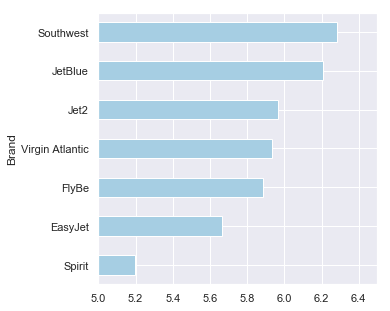

In [122]:
brand_sat = pd.DataFrame(Air_low_cost.groupby('Brand').apply(lambda x: np.average(x.Brand_Satisfaction, weights=x.weights)))
brand_sat = brand_sat.rename(columns={0:'Brand_Satisfaction'})
brand_sat.sort_values('Brand_Satisfaction',ascending=True)['Brand_Satisfaction'].plot(kind='barh',stacked=True,colormap='Paired',xlim=(5,6.5),figsize=(5,5))

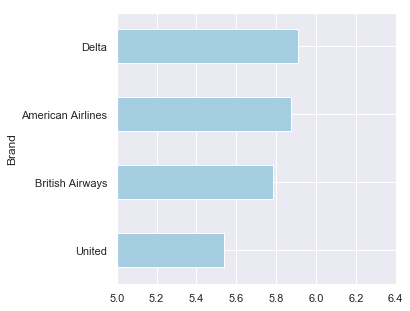

In [123]:
brand_sat = pd.DataFrame(Air_traditional.groupby('Brand').apply(lambda x: np.average(x.Brand_Satisfaction, weights=x.weights)))
brand_sat = brand_sat.rename(columns={0:'Brand_Satisfaction'})
brand_sat.sort_values('Brand_Satisfaction',ascending=True)['Brand_Satisfaction'].plot(kind='barh',stacked=True,colormap='Paired',xlim=(5,6.4),figsize=(5,5))

In [124]:
# For Low_cost
Air_low_cost = Air_low_cost.drop(columns=['Brand_Satisfaction','Brand'])
bi_logistic(Air_low_cost,"Overall Quality","Aircraft Comfort")

,Features,Coefficient,p_value
0,Overall Quality,1.006465,0.000000
8,Aircraft Comfort,0.682954,0.000000
2,Variety of Options,0.478172,0.000000
7,Cabin Crew,0.434991,0.000000
3,Pricing,0.244516,0.000000
5,In-flight Experience,0.000862,0.000000
1,Loyalty Program,-0.070650,0.000000
6,In-flight food&Beverage,-0.091931,0.768664
4,Product/Service availability,-0.102540,0.000000


In [125]:
# For Traditional airlines
Air_traditional = Air_traditional.drop(columns=['Brand_Satisfaction','Brand'])
bi_logistic(Air_traditional,"Overall Quality","Aircraft Comfort")

,Features,Coefficient,p_value
0,Overall Quality,1.672246,0.0
8,Aircraft Comfort,0.303389,0.0
3,Pricing,0.269730,0.0
5,In-flight Experience,0.251627,0.0
1,Loyalty Program,0.193484,0.0
4,Product/Service availability,0.171331,0.0
6,In-flight food&Beverage,-0.080939,0.0
2,Variety of Options,-0.114613,0.0
7,Cabin Crew,-0.164207,0.0


<h3> Hospitality </h3>

In [126]:
hos  = data[data['Programming_Category'] == 'Hospitality']
hos  = hos[['Brand','weights','Q67'] + list(hos.loc[:,'Q68_1':'Q68_5']) + list(hos.loc[:,'Q68_16':'Q68_20'])].set_index(['weights','Brand'])
hos =  hos.rename(columns={'Q67':'Brand_Satisfaction',
                          'Q68_1':'Overall Quality',
                          'Q68_2':'Loyalty Program',
                         'Q68_3':'Variety of Options',
                         'Q68_4':'Pricing',
                         'Q68_5':'Product/Service availability',
                         'Q68_16':'Room Cleaness & Comfort',
                         'Q68_17':'Food & Dining',
                          'Q68_18':'Spa,pool & fitness Center',
                         'Q68_19':'Activities, excursions and entertainment',
                         'Q68_20':'Business Center & Conference Room'})

In [127]:
hos = hos[hos.loc[:,"Brand_Satisfaction":"Business Center & Conference Room"] != " "].fillna(0).apply(pd.to_numeric)
hos.loc[:,"Brand_Satisfaction":"Business Center & Conference Room"] = hos.loc[:,"Brand_Satisfaction":"Business Center & Conference Room"].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=2)
hos.loc[:,"Overall Quality":"Business Center & Conference Room"] = imputer.fit_transform(hos.loc[:,"Overall Quality":"Business Center & Conference Room"])
hos.loc[:,"Overall Quality":"Business Center & Conference Room"] = hos.loc[:,"Overall Quality":"Business Center & Conference Room"].astype(str).apply(pd.to_numeric)
hos.reset_index(inplace=True)
hos = hos[(hos['Brand_Satisfaction']!=4)]
hos.loc[hos['Brand_Satisfaction']>=5, 'Satisfaction_tier'] = 1
hos.loc[hos['Brand_Satisfaction']<=3, 'Satisfaction_tier'] = 0

In [128]:
hotel_list = ['Courtyard by Marriott','Crowne Plaza','Center Parcs','Disney Hotels / Theme Parks / Cruises','Hilton',
         'InterContinental','Carnival','Doubletree','Embassy Suites',
         'La Quinta','Marriott','Novotel','Sheraton','Wyndham','Hyatt','Westin']

inn_others_list = ['Residence Inn','Comfort Inn','Comfort Inn Suites','Holiday Inn','Days Inn','Hampton Inn','Fairfield Inn','Holiday Inn Express','Super 8']
hotel = hos[hos.Brand.isin(hotel_list)]
inn = hos[hos.Brand.isin(inn_others_list)]
Airbnb = hos[hos['Brand'] == 'Airbnb']

In [129]:
hotel = hotel.drop(columns=['Brand_Satisfaction','Brand'])
bi_logistic(hotel,"Overall Quality","Business Center & Conference Room")

,Features,Coefficient,p_value
0,Overall Quality,1.071621,0.0
4,Product/Service availability,0.589461,0.0
3,Pricing,0.277373,0.0
5,Room Cleaness & Comfort,0.268389,0.0
6,Food & Dining,0.264669,0.0
7,"Spa,pool & fitness Center",0.253851,0.0
8,"Activities, excursions and entertainment",-0.108657,0.0
2,Variety of Options,-0.126080,0.0
9,Business Center & Conference Room,-0.143482,0.0
1,Loyalty Program,-0.236485,0.0


In [130]:
inn = inn.drop(columns=['Brand_Satisfaction','Brand'])
bi_logistic(inn,"Overall Quality","Business Center & Conference Room")

,Features,Coefficient,p_value
0,Overall Quality,1.060408,0.0
1,Loyalty Program,0.472827,0.0
4,Product/Service availability,0.287917,0.0
7,"Spa,pool & fitness Center",0.285345,0.0
3,Pricing,0.183754,0.0
5,Room Cleaness & Comfort,0.137361,0.0
2,Variety of Options,0.082004,0.0
6,Food & Dining,0.081578,0.0
9,Business Center & Conference Room,0.056787,0.0
8,"Activities, excursions and entertainment",-0.534519,0.0


In [131]:
Airbnb = Airbnb.drop(columns=['Brand_Satisfaction','Brand'])
bi_logistic(Airbnb,"Overall Quality","Business Center & Conference Room")

,Features,Coefficient,p_value
0,Overall Quality,0.795241,0.000000e+00
6,Food & Dining,0.468331,0.000000e+00
2,Variety of Options,0.276635,0.000000e+00
9,Business Center & Conference Room,0.227394,0.000000e+00
1,Loyalty Program,0.224520,0.000000e+00
5,Room Cleaness & Comfort,0.223850,0.000000e+00
4,Product/Service availability,0.149538,5.451193e-07
8,"Activities, excursions and entertainment",0.125969,0.000000e+00
3,Pricing,-0.045296,0.000000e+00
7,"Spa,pool & fitness Center",-0.526137,0.000000e+00


<h3> Product/Service Future Purchase Likelihood </h3>

In [60]:
Grocery = data[data['Programming_Category'] == 'Traditional Grocery']

In [61]:
def Future_product_likelihood(data,start,stop,brand):
    df = data[['Brand','weights'] + list(data.loc[:,start:stop]) ]
    df = df[df['Brand']==brand]
    df.iloc[:,1:] = df[df.iloc[:,1:] != " "].fillna(0).apply(pd.to_numeric)
    df = df.drop(['Brand'],axis=1)
    df=df.set_index('weights')
    df = pd.DataFrame(df.stack())
    df.reset_index(inplace=True)
    df = df.rename(columns={'level_1':'Index',0:'Future_Product_Likelihood'})
    df = df[df['Future_Product_Likelihood'] !=0]
    df = pd.merge(df,Re_dict , how='inner', on='Index')
    
    # Calculate the weighted average
    df = pd.DataFrame(df.groupby('Product').apply(lambda x: np.average(x.Future_Product_Likelihood, weights=x.weights)))
    df = df.rename(columns={0:'Future_Product_Likelihood'})
    return df

In [4]:
grocery_dict = pd.read_csv("/Users/ning/Desktop/Publicis Sapient/Grocery.csv")
grocery_dict['Product'] = grocery_dict['Product'].str[29:]

In [63]:
def grocery(data,start,stop,brand): 
    df = data[['Brand','weights'] + list(data.loc[:,start:stop])]
    df = df[df['Brand'] == brand]
    df.iloc[:,1:] = df[df.iloc[:,1:] != " "].fillna(0).apply(pd.to_numeric)
    df.loc[:,start:stop] = df.loc[:,start:stop].mul(df['weights'], axis=0)
    df = pd.DataFrame(df.loc[:,start:stop].sum(axis=0))
    df = df.rename(columns={0:"Sum"}).sort_values(by='Sum',ascending=False)
    df.reset_index(inplace=True)
    df= df.rename(columns={'index':'Index'})
    df_prd = pd.merge(df, grocery_dict, how='inner', on='Index')
    df_prd['std_Sum'] = (df_prd['Sum'] - df_prd['Sum'].mean())/df_prd['Sum'].std()
    df_prd['Brand'] = [brand for i in range(df_prd.shape[0])]
    return df_prd

In [64]:
Grocery_df = pd.DataFrame()
Brand_list = list(Grocery['Brand'].unique())
for i in Brand_list:
    new_df = grocery(Grocery,"Q3_Grocery_1","Q3_Grocery_19",i)
    Grocery_df = Grocery_df.append(new_df)

In [65]:
Grocery_df['Product_Sum'] = Grocery_df.groupby(Grocery_df['Product'])['Sum'].transform('sum')
Grocery_df['Percentage'] = Grocery_df['Sum']/Grocery_df['Product_Sum']

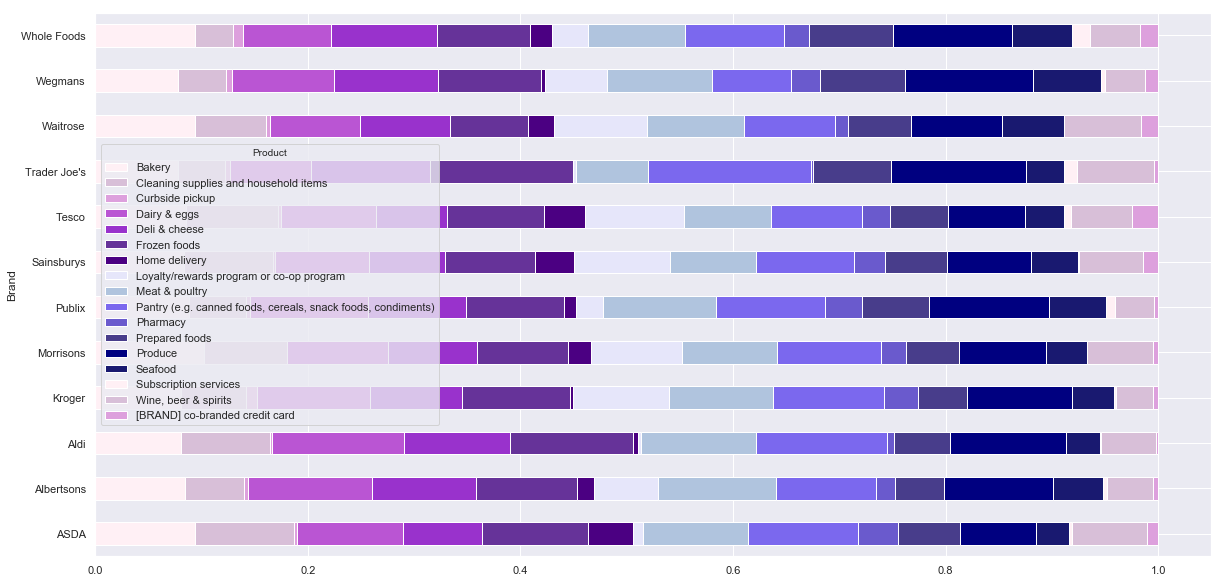

In [78]:
# Grocery_df['Brand_Product_Sum'] = Grocery_df.groupby(Grocery_df['Brand'])['Sum'].transform('sum')
# Grocery_df['Product_Brand_Pct'] = Grocery_df['Sum']/Grocery_df['Brand_Product_Sum']
# pivot_df2 = Grocery_df.pivot(index='Brand', columns='Product', values='Product_Brand_Pct')
# pivot_df2.plot.barh(stacked=True, color=colors, figsize=(20,10))

In [67]:
# Just take few product as example:
product_list = ['Home delivery','Meat & poultry','Pharmacy','Prepared foods','Wine, beer & spirits','Seafood','Bakery']
Grocery_df_sub = Grocery_df[Grocery_df.Product.isin(product_list)]

In [68]:
Grocery_df['Product'].unique()

array(['Loyalty/rewards program or co-op program', 'Frozen foods',
       'Dairy & eggs', 'Cleaning supplies and household items', 'Bakery',
       'Pantry (e.g. canned foods, cereals, snack foods, condiments)',
       'Meat & poultry', 'Produce', 'Deli & cheese',
       'Wine, beer & spirits', 'Prepared foods', 'Home delivery',
       'Seafood', 'Pharmacy', '[BRAND] co-branded credit card',
       'Subscription services', 'Curbside pickup'], dtype=object)

In [69]:
pivot_df = Grocery_df_sub.pivot(index='Product', columns='Brand', values='Percentage')

In [70]:
colors = ['midnightblue','mistyrose','darksalmon','sienna','firebrick','brown','maroon','lavender','lightsteelblue','mediumslateblue','slateblue','darkslateblue','navy','seashell']

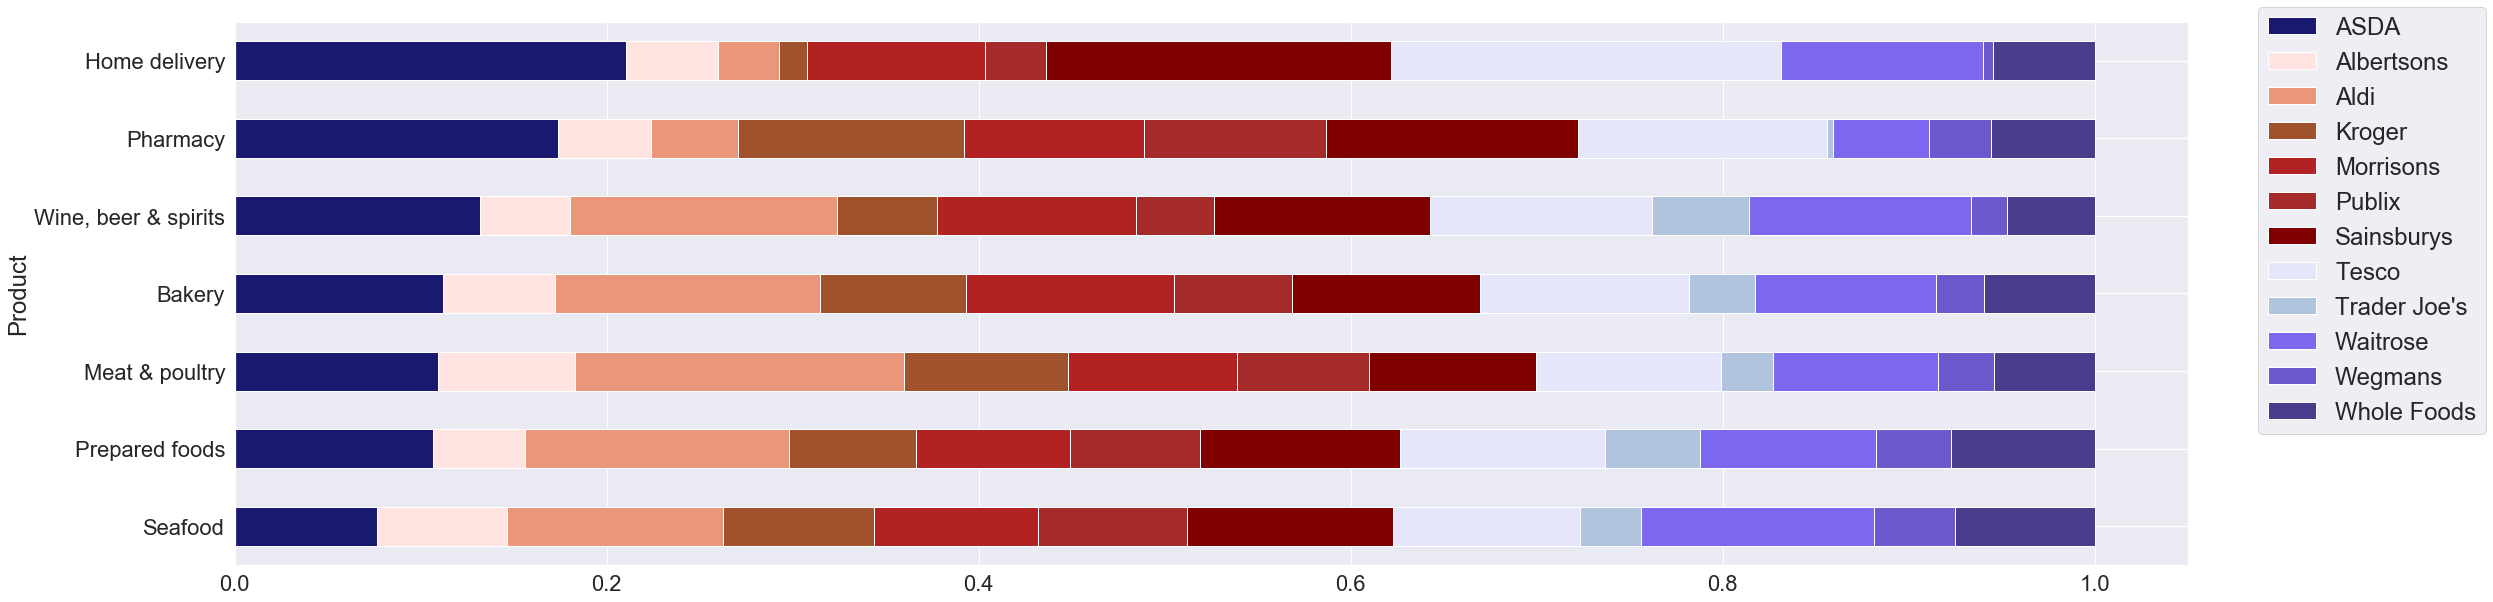

In [71]:
pivot_df.sort_values('ASDA').plot.barh(stacked=True, color=colors, figsize=(35,10))
ax = plt.subplot(111)
ax.legend(prop={'size': 24}, bbox_to_anchor=(1.03, 1.05))
sns.set(font_scale=2)

In [ ]:
data.head()

## Banking

In [7]:
data['Brand'][data['Programming_Category']=='Banking & Credit Cards'].unique()

array(['Chase', 'Lloyds', 'Barclays', 'TD Financial', 'Discover', 'Citi',
       'Bank of America', 'Royal Bank of Scotland', 'Wells Fargo',
       'Capital One', 'American Express', 'USAA', 'HSBC', 'US Bank',
       'Ally'], dtype=object)

In [8]:
data = data.replace({'Q12' : { '1' : 'Visa', '2' : 'MasterCard', '3' : 'American Express' , '4':'Discover', '6':'Other'}})

In [9]:
df = data[['Programming_Category', 'Brand', 'weights'] + list(data.loc[:, 'S1':'S3_US_States']) +
          list(data.loc[:, 'Q5':'Q5']) + list(data.loc[:, 'Q74':'Q75']) + 
          list(data.loc[:, 'Q3_BankingCreditCards_1':'Q3_BankingCreditCards_6']) + 
          list(data.loc[:, 'Q9_NUMBER_CategoryTransactions':'Q15c_Other_Loans']) + 
          list(data.loc[:, 'Q67':'Q68_11']) + list(data.loc[:, 'Q55':'Q55']) +
          list(data.loc[:, 'Q59_1':'Q59_10']) + list(data.loc[:, 'Q72_1':'Q73_40'])] 
df.head()

,Programming_Category,Brand,weights,S1,S1_Age_Bucketed,S2,S3_US_States,Q5,Q74,Q75,...,Q73_31,Q73_32,Q73_33,Q73_34,Q73_35,Q73_36,Q73_37,Q73_38,Q73_39,Q73_40
0,Hospitality,Sheraton,0.740059,30,4,2,33,1,7,5,...,7,7,7,7,7,7,7,7,7,2
2,Hospitality,Sheraton,0.794263,36,5,2,31,9,7,4,...,5,7,6,6,5,6,5,4,4,2
4,Hospitality,InterContinental,0.740059,25,3,2,14,5,2,3,...,1,5,6,5,5,2,1,2,2,5
7,Hospitality,InterContinental,5.797803,18,2,1,44,6,9,7,...,7,7,7,7,7,7,7,7,7,7
8,Hospitality,Crowne Plaza,1.745836,18,2,2,29,1,3,3,...,5,4,5,6,5,4,4,4,4,5


In [10]:
def rename(data):
    data = data[data !=" "]
    data[['Q59_1','Q59_2','Q59_3','Q59_4','Q59_5','Q59_6','Q59_7','Q59_8','Q59_9','Q59_10','Q68_6','Q68_7',
          'Q68_8','Q68_9','Q68_10','Q68_11']] = data[['Q59_1','Q59_2','Q59_3','Q59_4','Q59_5','Q59_6','Q59_7',
                                                      'Q59_8','Q59_9','Q59_10','Q68_6','Q68_7','Q68_8','Q68_9','Q68_10','Q68_11']].apply(pd.to_numeric)
    
    data = data.rename(columns = {'Q59_1': 'Website', 
                                  'Q59_2':'Mobile_app', 
                                  'Q59_3':'Push Notification', 
                                  'Q59_4':'Phone_calls', 
                                  'Q59_5':'SMS/Text_Message', 
                                  'Q59_6':'Emails', 
                                  'Q59_7':'Social_Media',
                                  'Q59_8':'Live_Chat',
                                  'Q59_9':'in-person retail branches',
                                  'Q59_10':'ATMs',
                                  'Q68_6':'Proximity of Branch/ATM',
                                  'Q68_7':'Benefits, Perks',
                                  'Q68_8':'Financial advisory services',
                                  'Q68_9':'Credit card rewards earning',
                                  'Q68_10':'Credit card rewards redemption',
                                  'Q68_11':'Acceptance of card by merchant',
                                  'Q55':'Booking Preference'})
    # Here we try to remove those people who seems to rush through the survey and remain neutral to every answer
    
    data = data[(data['Website'] !=4)  | (data['Mobile_app'] !=4) |(data['Push Notification'] !=4) 
                  |(data['Phone_calls'] !=4) |(data['SMS/Text_Message'] !=4)|(data['Emails'] !=4) |(data['Social_Media']!=4) |(data['Live_Chat'] !=4) ]
    return data

df = rename(df)

In [11]:
df = df.rename(columns = {'S1': 'Age', 'S1_Age_Bucketed' : 'A_bucket', 'S2' : 'Gender',                      
                          'Q9_NUMBER_CategoryTransactions' : 'Q9_#CatTrxn', 'Q11' : 'CC Primary',
                          'Q12' : 'CC Network', 'Q13' : 'CC Netw_Impact', 'Q56' : 'Brand feeling',
                          'Q67' : 'Brand_Satisfaction', 'Q68_1' : 'Product','Q68_2' : 'Loyalty prog',
                          'Q68_3' : 'Variety opt.', 'Q68_4' : 'Pricing', 'Q68_5' : 'Availability',
                          'Q5':'Repurchase Likelihood', 'Q74':'Willingness to Recommend',
                          'Q75':'Likelihood to try new',
                          'Q3_BankingCreditCards_1':'Own_Checking', 'Q3_BankingCreditCards_4':'Own_Savings',
                          'Q3_BankingCreditCards_5':'Own_CreditC', 'Q3_BankingCreditCards_6':'Own_DebitC',
                          'Q3_BankingCreditCards_7':'Own_Mortgage'})    

df['Gender_str'] = np.where(df['Gender'] == 1, 'Male', 'Female')

In [12]:
bank = df[(df['Programming_Category']=='Banking & Credit Cards')]
bank = bank.fillna(0)

In [13]:
#Turn all values to numeric if possible

for c in bank.columns:
    try:   
        bank[c] = bank[c].apply(pd.to_numeric)
    except:
        pass

In [14]:
#Customer Engagement Attributes
bank['Attr_Advocacy'] = (bank['Q72_1'] + bank['Q72_2'] + bank['Q72_3'])/3
bank['Attr_Choice'] = bank['Q72_4']
bank['Attr_Distress_if_discontinued'] = bank['Q72_5']
bank['Attr_Invested in brand success'] = (bank['Q72_6'] + bank['Q72_7'])/2
bank['Attr_Self_connected'] = bank['Q72_8']
bank['Attr_Self_expression'] = bank['Q72_9']
bank['Attr_Trust'] = (bank['Q72_10'] + bank['Q72_11'])/2
bank['Attr_Choice'] = bank['Q72_12']
bank['Attr_Expectation'] = bank['Q72_13']
bank['Attr_Inspiration'] = bank['Q72_14']
bank['Attr_Magic & Transformation'] = bank['Q72_15']
bank['Attr_Social & responsibility'] = bank['Q72_16']
bank['Attr_Utilitarian'] = bank['Q72_17']
bank['Attr_Values alignment'] = bank['Q72_18']
bank['Attr_Enjoyment'] = bank['Q72_19']
bank['Attr_Pride'] = bank['Q72_20']

#Customer Engagement Drivers
bank['Driver_Accessibility'] = (bank['Q73_1'] + bank['Q73_2'] + bank['Q73_3'] + bank['Q73_4'])/4
bank['Driver_Consistency'] = (bank['Q73_5'] + bank['Q73_6'] + bank['Q73_7'])/3
bank['Driver_Ease of use'] = bank['Q73_8']
bank['Driver_Empathy'] = (bank['Q73_9'] + bank['Q73_10'] + bank['Q73_11'])/3
bank['Driver_Latest & Greatest'] = (bank['Q73_12'] + bank['Q73_12'])/2
bank['Driver_Leadership'] = (bank['Q73_14'] + bank['Q73_15'])/2
bank['Driver_Memorable & Nostalgia'] = bank['Q73_16']
bank['Driver_Personalization'] = (bank['Q73_17'] + bank['Q73_18'] + bank['Q73_19'] 
                                + bank['Q73_20'] + bank['Q73_21'] + bank['Q73_22'])/6

bank['Driver_Price'] = bank['Q73_23']
bank['Driver_Product/Service Quality'] = (bank['Q73_24'] + bank['Q73_25'])/2
bank['Driver_Data & Security'] = (bank['Q73_26'] + bank['Q73_27'])/2

bank['Driver_Self-Expression'] = (bank['Q73_28'] + bank['Q73_29'])/2
bank['Driver_Social Proof'] =(bank['Q73_30'] + bank['Q73_31'])/2
bank['Driver_Social Responsibility'] = (bank['Q73_32'] + bank['Q73_33'])/2
bank['Driver_Trust/Authenticity'] = (bank['Q73_34'] + bank['Q73_34'])/2
bank['Driver_Value'] = (bank['Q73_36'] + bank['Q73_36'])/2
bank['Driver_Information'] = bank['Q73_38']
bank['Driver_Category Impact'] = bank['Q73_39']

In [15]:
bank.head()

,Programming_Category,Brand,weights,Age,A_bucket,Gender,S3_US_States,Repurchase Likelihood,Willingness to Recommend,Likelihood to try new,...,Driver_Price,Driver_Product/Service Quality,Driver_Data & Security,Driver_Self-Expression,Driver_Social Proof,Driver_Social Responsibility,Driver_Trust/Authenticity,Driver_Value,Driver_Information,Driver_Category Impact
4931,Banking & Credit Cards,Chase,0.524476,69,8,2,5,8,9,4,...,5,5.5,5.0,4.0,4.0,4.0,4.0,4.0,4,4
4935,Banking & Credit Cards,Lloyds,0.820253,39,5,2,-99,9,9,4,...,7,6.0,6.0,4.0,4.5,4.5,7.0,6.0,5,6
4937,Banking & Credit Cards,Lloyds,0.631658,62,7,1,-99,8,0,4,...,6,5.5,5.0,1.0,2.5,4.0,5.0,5.0,5,7
4951,Banking & Credit Cards,Chase,0.548427,57,7,2,29,6,5,4,...,5,4.0,2.5,3.0,3.0,3.0,4.0,5.0,4,4
4963,Banking & Credit Cards,Barclays,0.631658,59,7,1,-99,6,5,5,...,4,4.5,5.0,4.0,4.0,4.0,5.0,4.0,4,5


## Per Bank Statistics & Preliminary Analysis

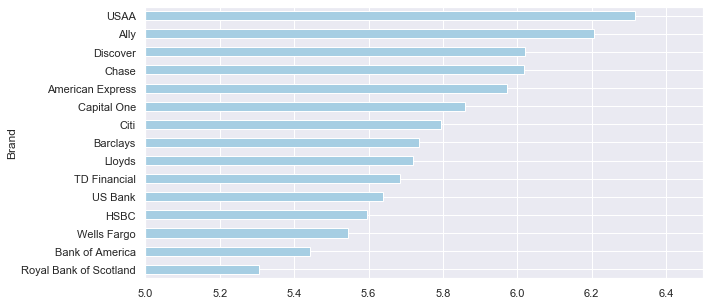

In [16]:
# Calculate weighted average brand satisfaction

brand_sat = pd.DataFrame(bank.groupby('Brand').apply(lambda x: np.average(x.Brand_Satisfaction, weights=x.weights)))
brand_sat = brand_sat.rename(columns={0:'Brand_Satisfaction'})
brand_sat.sort_values('Brand_Satisfaction',ascending=True)['Brand_Satisfaction'].plot(kind='barh',stacked=True,colormap='Paired',xlim=(5,6.5),figsize=(10,5))

Text(0.5, 1.0, 'All Banks')

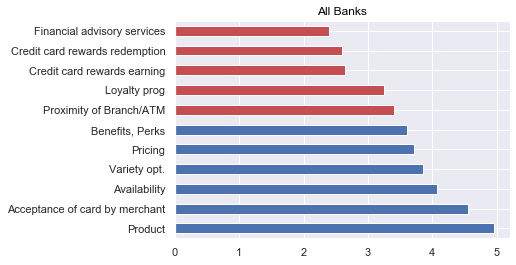

In [17]:
#Brand satisfaction Product/Services

bank_w = bank.loc[:,'Product':'Acceptance of card by merchant'].mul(bank['weights'],axis=0)
avg = np.mean(bank_w.mean())
col = np.where(bank_w.mean().sort_values(ascending = False) < avg,'r','b')

bank_w.mean().sort_values(ascending = False).plot(kind = 'barh', color = col)
plt.title('All Banks', color = 'Black')

Text(0.5, 1.0, 'All Banks - Age <= 40')

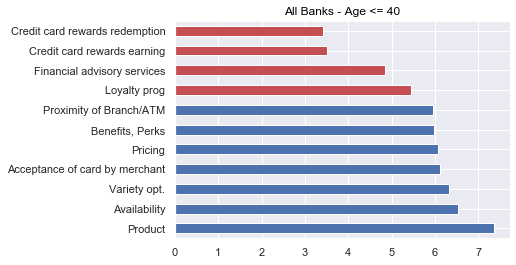

In [20]:
#Brand satisfaction Product/Services per ages

young = bank[bank['Age'] <= 40]
older = bank[bank['Age'] > 40]

bank_w = young.loc[:,'Product':'Acceptance of card by merchant'].mul(bank['weights'],axis=0)
avg = np.mean(bank_w.mean())
col = np.where(bank_w.mean().sort_values(ascending = False) < avg,'r','b')

bank_w.mean().sort_values(ascending = False).plot.barh(color = col)
plt.title('All Banks - Age <= 40', color = 'Black')

Text(0.5, 1.0, 'All Banks - Age > 40')

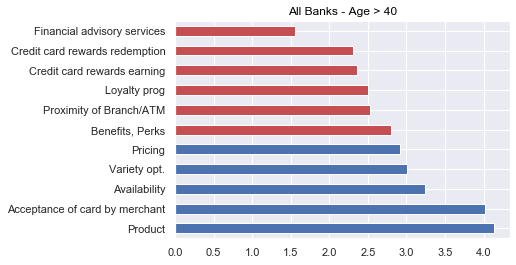

In [22]:
#Brand satisfaction Product/Services per ages
bank_w = older.loc[:,'Product':'Acceptance of card by merchant'].mul(bank['weights'],axis=0)

avg = np.mean(bank_w.mean())
col = np.where(bank_w.mean().sort_values(ascending = False) < avg,'r','b')

bank_w.mean().sort_values(ascending = False).plot.barh(color = col)
plt.title('All Banks - Age > 40', color = 'Black')

Text(0.5, 1.0, 'All Banks')

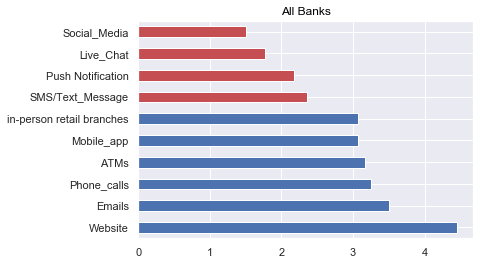

In [24]:
#Brand satisfaction Satisfaction Channels

bank_w = bank.loc[:,'Website':'ATMs'].mul(bank['weights'],axis=0)
avg = np.mean(bank_w.mean())
col = np.where(bank_w.mean().sort_values(ascending = False) < avg,'r','b')

bank_w.mean().sort_values(ascending = False).plot.barh(color = col)
plt.title('All Banks', color = 'Black')

# plt.scatter(x, y, c=col, s=5, linewidth=0)
# plt.show()

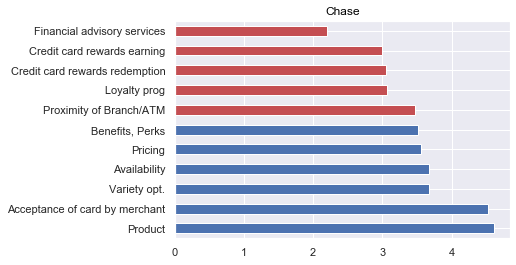

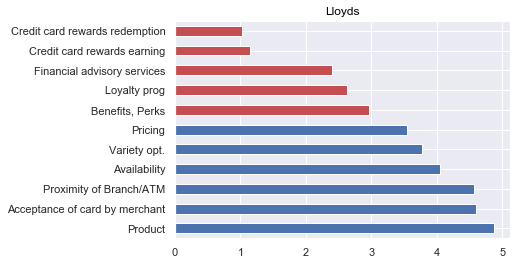

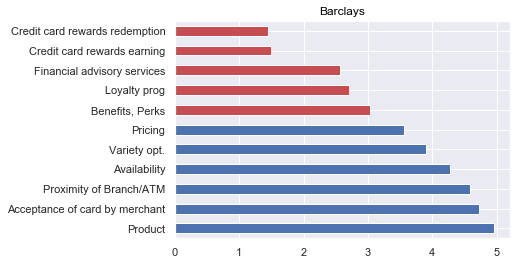

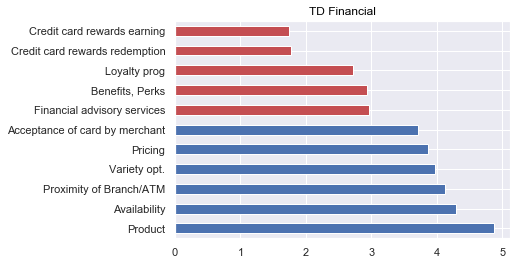

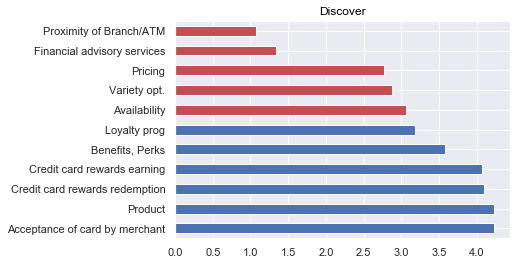

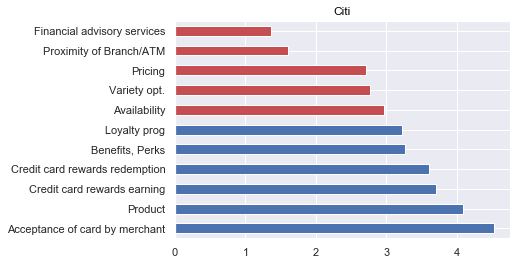

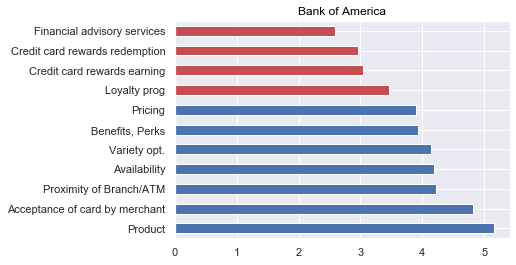

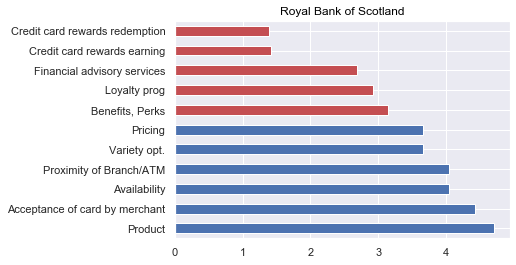

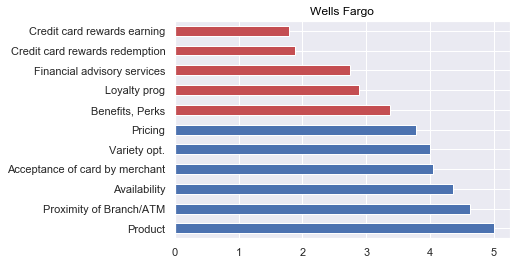

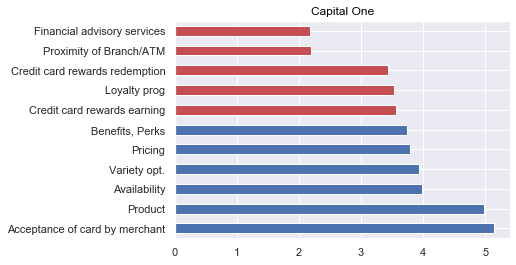

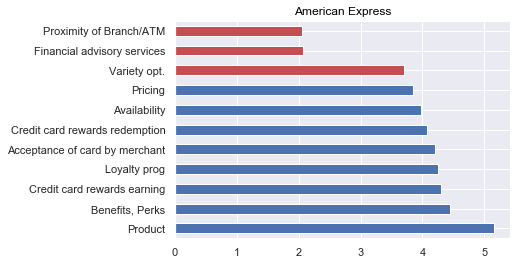

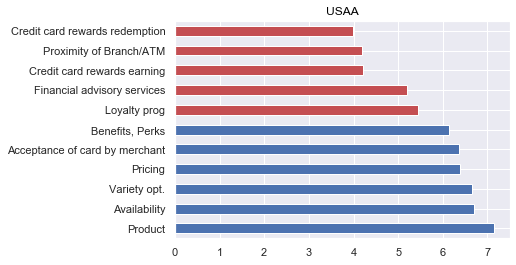

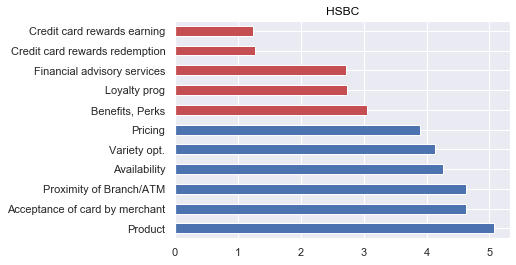

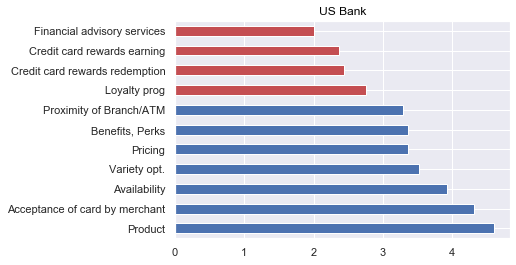

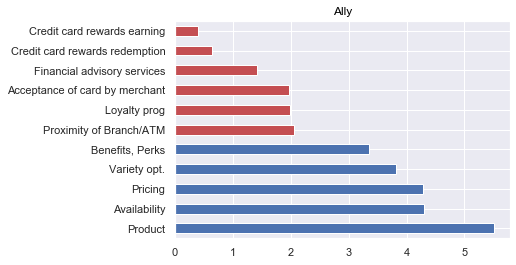

In [25]:
#Brand satisfaction per Product/Service

for current_brand in bank['Brand'].unique():
    banko = bank[bank['Brand'] == current_brand].loc[:,'Product':'Acceptance of card by merchant'].mul(bank['weights'],axis=0)
    avg = np.mean(banko.mean())
    col = np.where(banko.mean().sort_values(ascending = False) < avg,'r','b')
    banko.mean().sort_values(ascending = False).plot.barh(color = col)
    plt.title(current_brand, color = 'Black')
    plt.show()

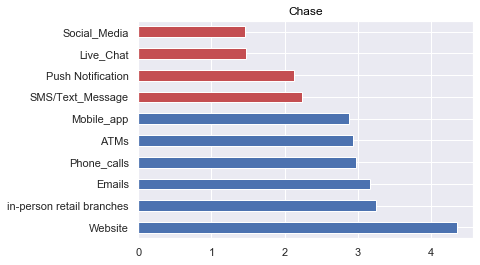

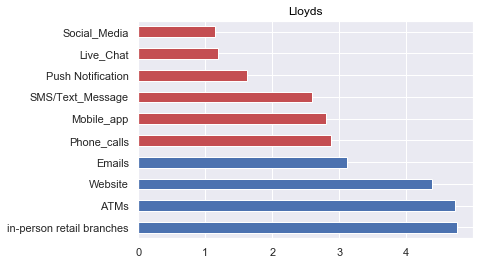

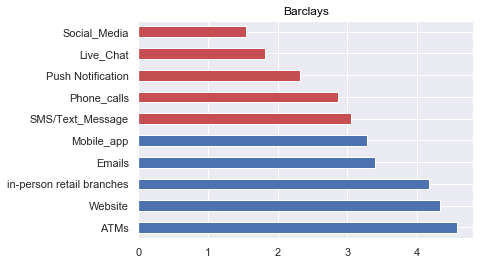

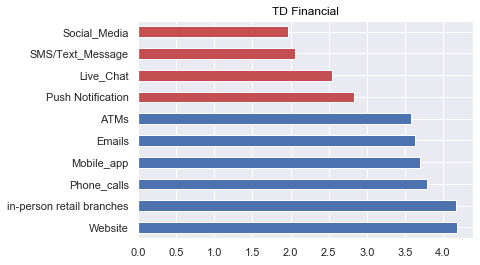

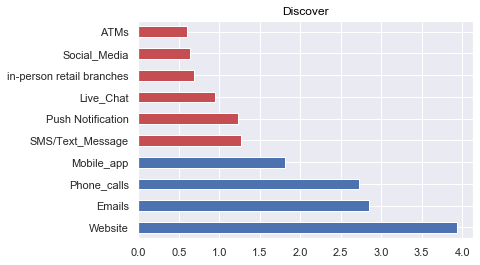

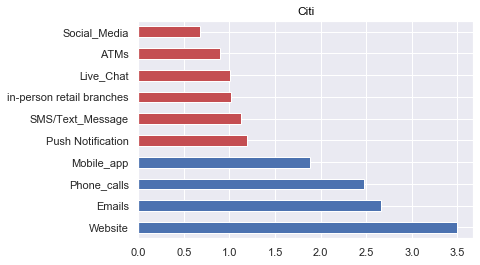

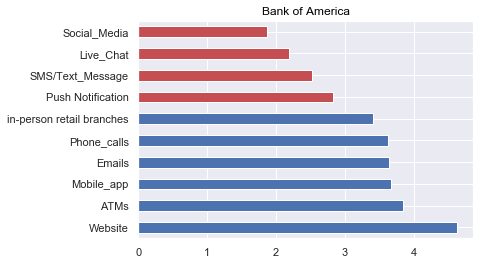

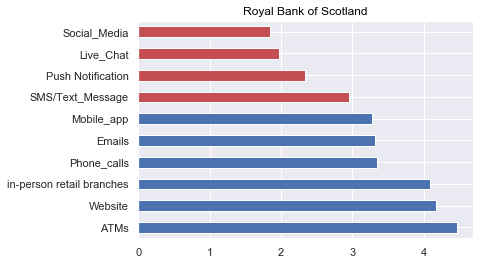

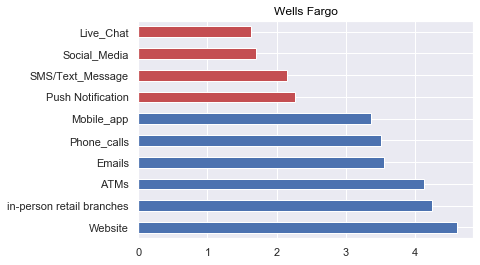

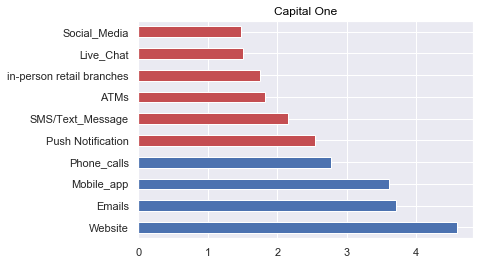

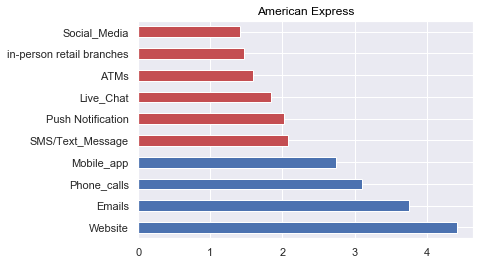

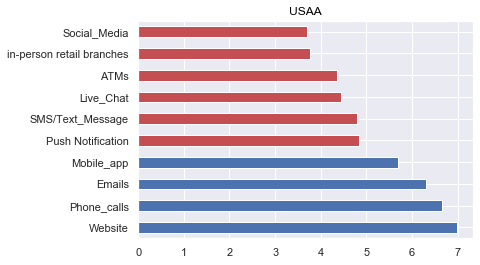

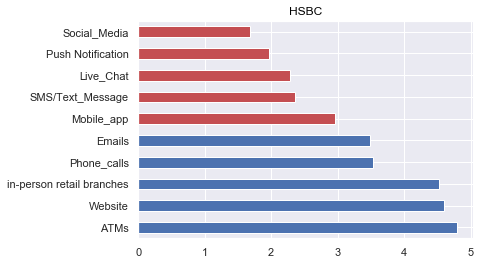

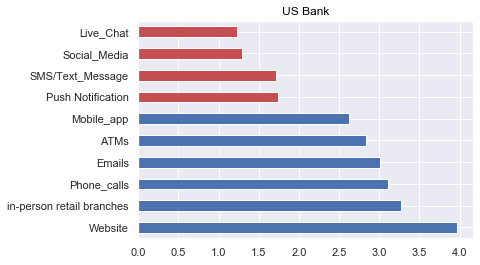

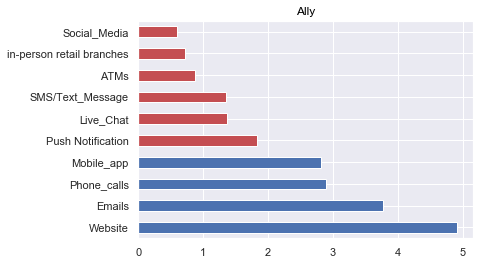

In [26]:
#Brand satisfaction per channel

for current_brand in bank['Brand'].unique():
    banko = bank[bank['Brand'] == current_brand].loc[:,'Website':'ATMs'].mul(bank['weights'],axis=0)
    avg = np.mean(banko.mean())
    col = np.where(banko.mean().sort_values(ascending = False) < avg,'r','b')
    banko.mean().sort_values(ascending = False).plot.barh(color = col)
    plt.title(current_brand, color = 'Black')
    plt.show()

In [28]:
def tier_transformation(data):
    #tier = data[['weights'] + list(data.loc[:,'Q59_1_Tiers':'Q59_8_Tiers'])].set_index(['weights'])
    
    #CHANGE NEXT LINE Brand = XXX to pick brand
    
    tier = data[(data['Programming_Category']=='Banking & Credit Cards') & (data['Brand'] == 'Capital One')][['weights'] + 
                    list(data.loc[:,'Q59_1_Tiers':'Q59_8_Tiers'])].set_index(['weights'])
    tier[['Q59_1_Tiers','Q59_2_Tiers','Q59_3_Tiers','Q59_4_Tiers','Q59_5_Tiers','Q59_6_Tiers','Q59_7_Tiers','Q59_8_Tiers']] = tier[['Q59_1_Tiers','Q59_2_Tiers','Q59_3_Tiers','Q59_4_Tiers','Q59_5_Tiers','Q59_6_Tiers','Q59_7_Tiers','Q59_8_Tiers']].apply(pd.to_numeric)
    tier = tier.rename(columns = {'Q59_1_Tiers': 'website','Q59_2_Tiers':'Mobile_app', 'Q59_3_Tiers':'Push Notification',
                                  'Q59_4_Tiers':'Phone_calls','Q59_5_Tiers':'SMS/Text_Message','Q59_6_Tiers':'Emails',
                                  'Q59_7_Tiers':'Social_Media','Q59_8_Tiers':'Live_Chat'})
    tier = pd.DataFrame(tier.stack()).rename(columns = {0:'Satisfaction_tier'})
    tier = tier[(tier['Satisfaction_tier'] != 0) & (tier['Satisfaction_tier'] != -99)]
    tier.reset_index(level = 1,  inplace = True)
    tier = tier.rename(columns = {'level_1': 'Channel'})
    tier.reset_index(inplace=True)
    dfDummies_tier = pd.get_dummies(tier['Channel'])
    tier = pd.concat([tier, dfDummies_tier], axis=1).drop(columns=['Channel'])
    
    return tier

In [32]:
# Binomial Logistic Regression Model:

def bi_logistic(df,start,stop):
    X = df.loc[:,start:stop]
    y = df['Satisfaction_tier']
    sample_weight = df['weights']
    clf = LogisticRegression(random_state=0).fit(X, y,sample_weight=sample_weight)
    coef = []
    for i in range(len(X.columns)):
        coef.append([X.columns[i],clf.coef_[0][i]])
    coef = pd.DataFrame(coef,columns=['Features','Coefficient'])
    coef = coef.sort_values(by='Coefficient',ascending=False)
    return coef

In [33]:
tier = tier_transformation(data)

Text(0.5, 1.0, 'Binomial Logistic Regression for Capital One')

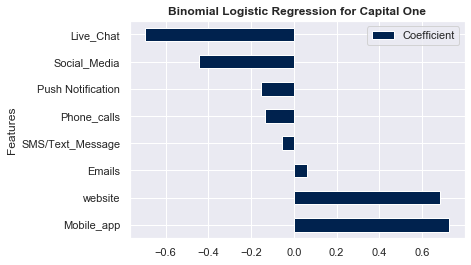

In [34]:
coef = bi_logistic(tier,'Emails','website')
coef = coef.set_index(['Features'])
coef.plot.barh(colormap = 'cividis')
plt.title('Binomial Logistic Regression for Capital One', weight = 'bold')

In [35]:
chan = list(bank.loc[:,'Product':'Acceptance of card by merchant'].columns)

#sub = bank[(bank['Brand']=='Chase') |( bank['Brand']=='USAA') | ( bank['Brand']=='US Bank')]
sub = bank[(bank['Brand']=='Discover') |( bank['Brand']=='Bank of America')]
Grouped = sub.groupby('Brand')

bank_group = Grouped.apply(lambda x: pd.Series(np.average(x.loc[:,'Product':'Acceptance of card by merchant'], weights=x["weights"], axis=0), chan))
bank_group = pd.DataFrame(bank_group.unstack())
bank_group.reset_index(inplace=True)
bank_group = bank_group.rename(columns={'level_0':'Area',0:'Satisfaction'})

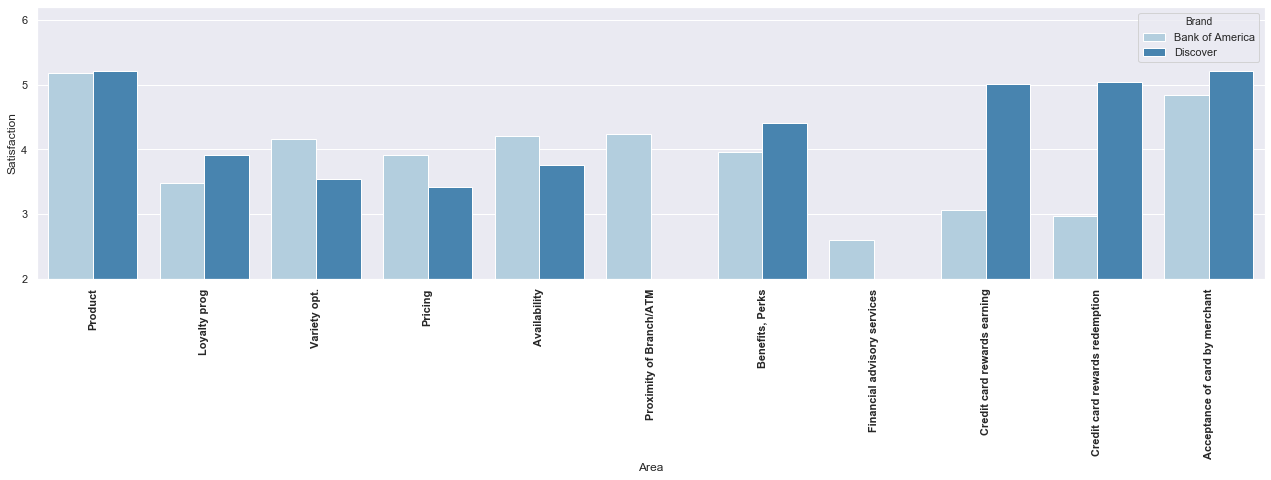

In [36]:
plt.figure(figsize=(22,5))
plt.ylim(2, 6.2)
plt.xticks(rotation = 'vertical', weight = 'bold')

sns.barplot(x='Area', hue="Brand", y='Satisfaction', data = bank_group, 
            palette="Blues")
sns.set(font_scale=2)

## Credit Card

In [37]:
cred = bank[bank['Own_CreditC']==1]
no_cred = bank[bank['Own_CreditC']==0]
cred.describe(percentiles = (0.5, 0.75, 0.9)).loc[['count','mean', '50%', '75%', '90%', 'max']]

,weights,Age,A_bucket,Gender,S3_US_States,Repurchase Likelihood,Willingness to Recommend,Likelihood to try new,Own_Checking,Own_Savings,...,Driver_Price,Driver_Product/Service Quality,Driver_Data & Security,Driver_Self-Expression,Driver_Social Proof,Driver_Social Responsibility,Driver_Trust/Authenticity,Driver_Value,Driver_Information,Driver_Category Impact
count,2815.000000,2815.000000,2815.000000,2815.000000,2815.00000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,...,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.000000,2815.00000,2815.000000,2815.000000,2815.00000
mean,0.890811,54.181883,6.386501,1.556306,-15.52611,6.824512,6.990409,4.516519,0.283126,0.264654,...,5.030906,4.933393,4.922202,4.119716,4.072469,4.356483,4.81421,4.847247,4.202131,4.48135
50%,0.740059,58.000000,7.000000,2.000000,10.00000,7.000000,7.000000,4.000000,0.000000,0.000000,...,5.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.00000,5.000000,4.000000,4.00000
75%,0.958459,66.000000,8.000000,2.000000,33.00000,8.000000,9.000000,5.000000,1.000000,1.000000,...,6.000000,6.000000,6.000000,5.000000,5.000000,5.000000,6.00000,6.000000,5.000000,5.00000
90%,1.853298,71.000000,8.000000,2.000000,44.00000,9.000000,10.000000,6.000000,1.000000,1.000000,...,7.000000,7.000000,7.000000,6.500000,6.000000,6.500000,7.00000,7.000000,7.000000,7.00000
max,5.797803,74.000000,8.000000,2.000000,51.00000,9.000000,10.000000,7.000000,1.000000,1.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.00000


In [38]:
no_cred.groupby('Brand').mean().loc[:, 'Q15_Brand_CashAccount':'Q15_Other_CashAccounts']

,Q15_Brand_CashAccount,Q15_Other_CashAccounts
Brand,,
Ally,18313.762712,80135.932203
American Express,824.263158,934.763158
Bank of America,4623.428571,18776.417582
Barclays,4505.506276,11776.882845
Capital One,1510.592593,6017.814815
Chase,3747.160000,7561.773333
Citi,9008.461538,3853.846154
Discover,0.000000,0.000000
HSBC,5871.680473,25835.088757


In [39]:
cred.groupby('Brand').mean().loc[:, 'Q15_Brand_CashAccount':'Q15_Other_CashAccounts']

,Q15_Brand_CashAccount,Q15_Other_CashAccounts
Brand,,
Ally,13386.857143,5429.285714
American Express,602.982759,1382.967433
Bank of America,5474.598131,4069.518692
Barclays,3345.564655,7234.806034
Capital One,527.269388,377.163265
Chase,3081.907216,4857.783505
Citi,1511.879377,3711.291829
Discover,1515.895307,8124.718412
HSBC,6631.500000,14866.737288


In [40]:
#Count of Brand respondents in CC

cred.groupby('Brand').count().loc[:, 'Brand_Satisfaction':'Brand_Satisfaction']

,Brand_Satisfaction
Brand,
Ally,7
American Express,522
Bank of America,214
Barclays,232
Capital One,245
Chase,194
Citi,257
Discover,277
HSBC,118


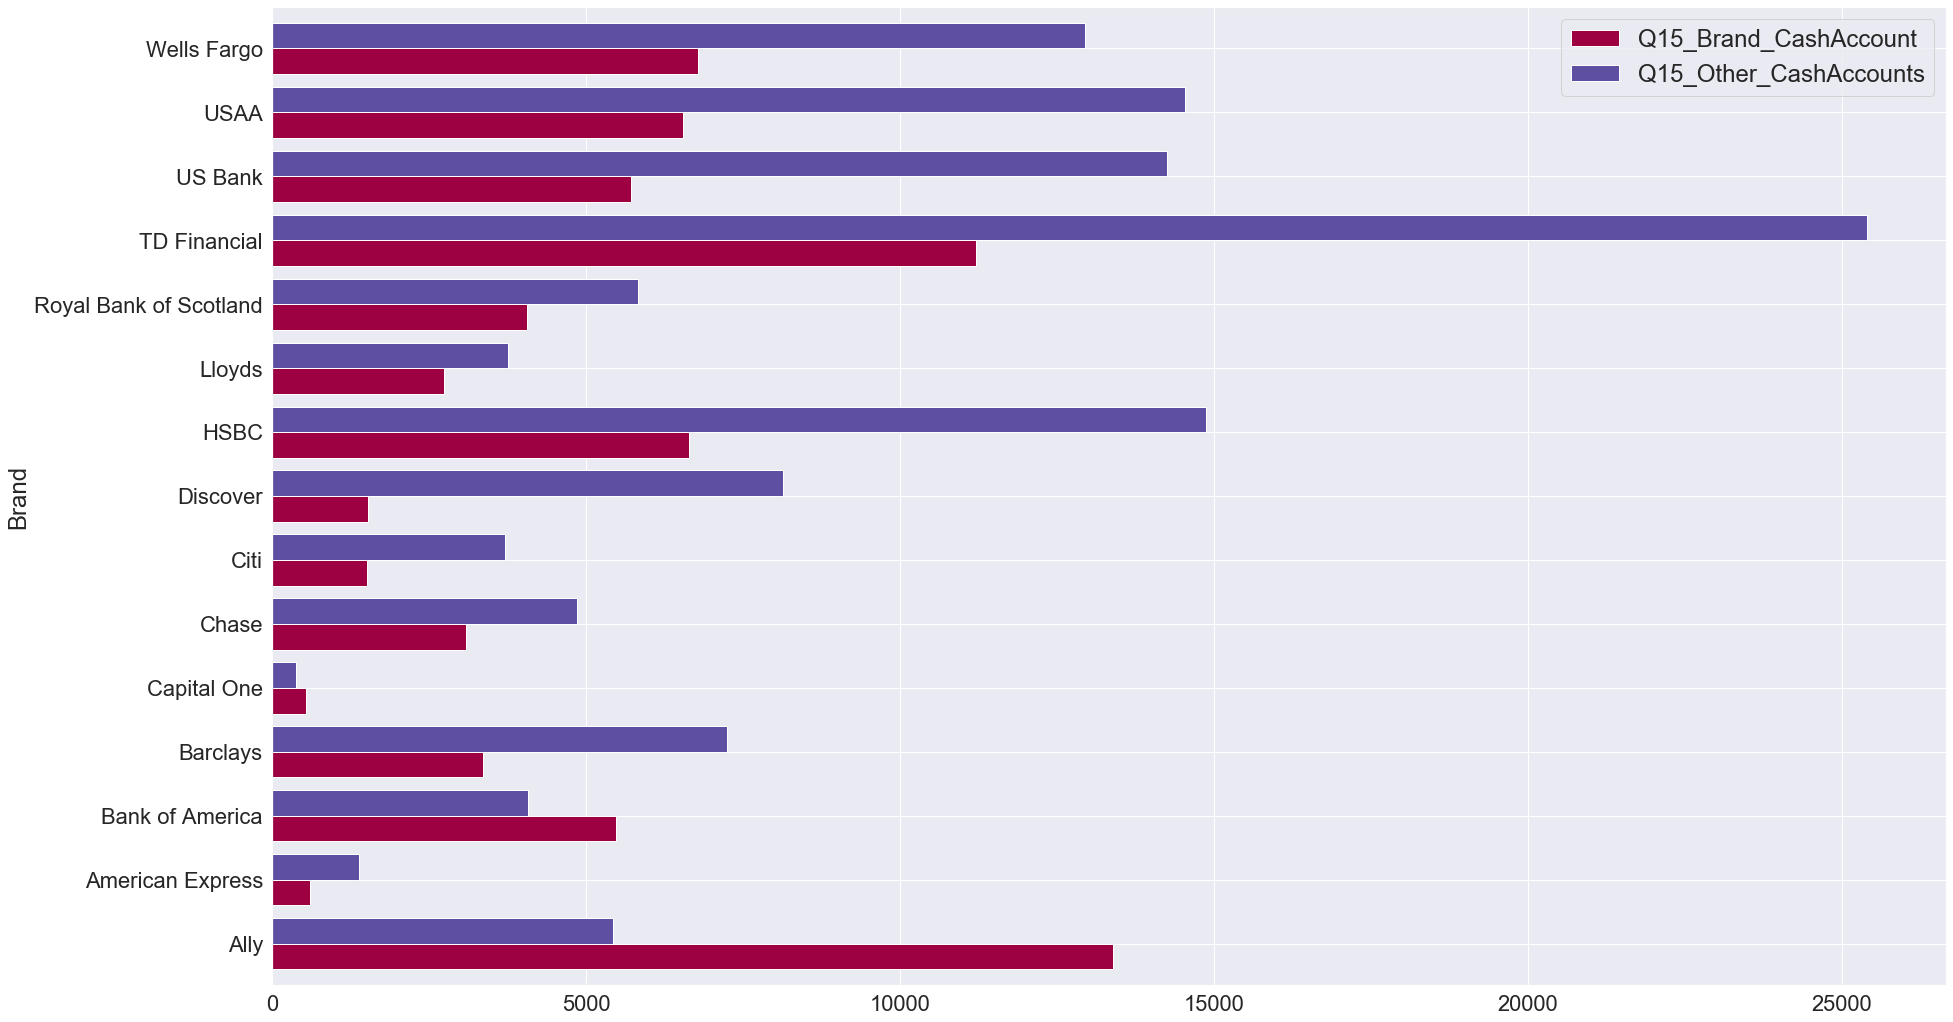

In [41]:
cred.groupby('Brand').mean().loc[:, 'Q15_Brand_CashAccount':'Q15_Other_CashAccounts'].plot.barh(width=0.8, figsize = (30,18), cmap = 'Spectral')
plt.legend(prop={'size': 24})

Text(0.5, 1.0, 'Means in each category per bank')

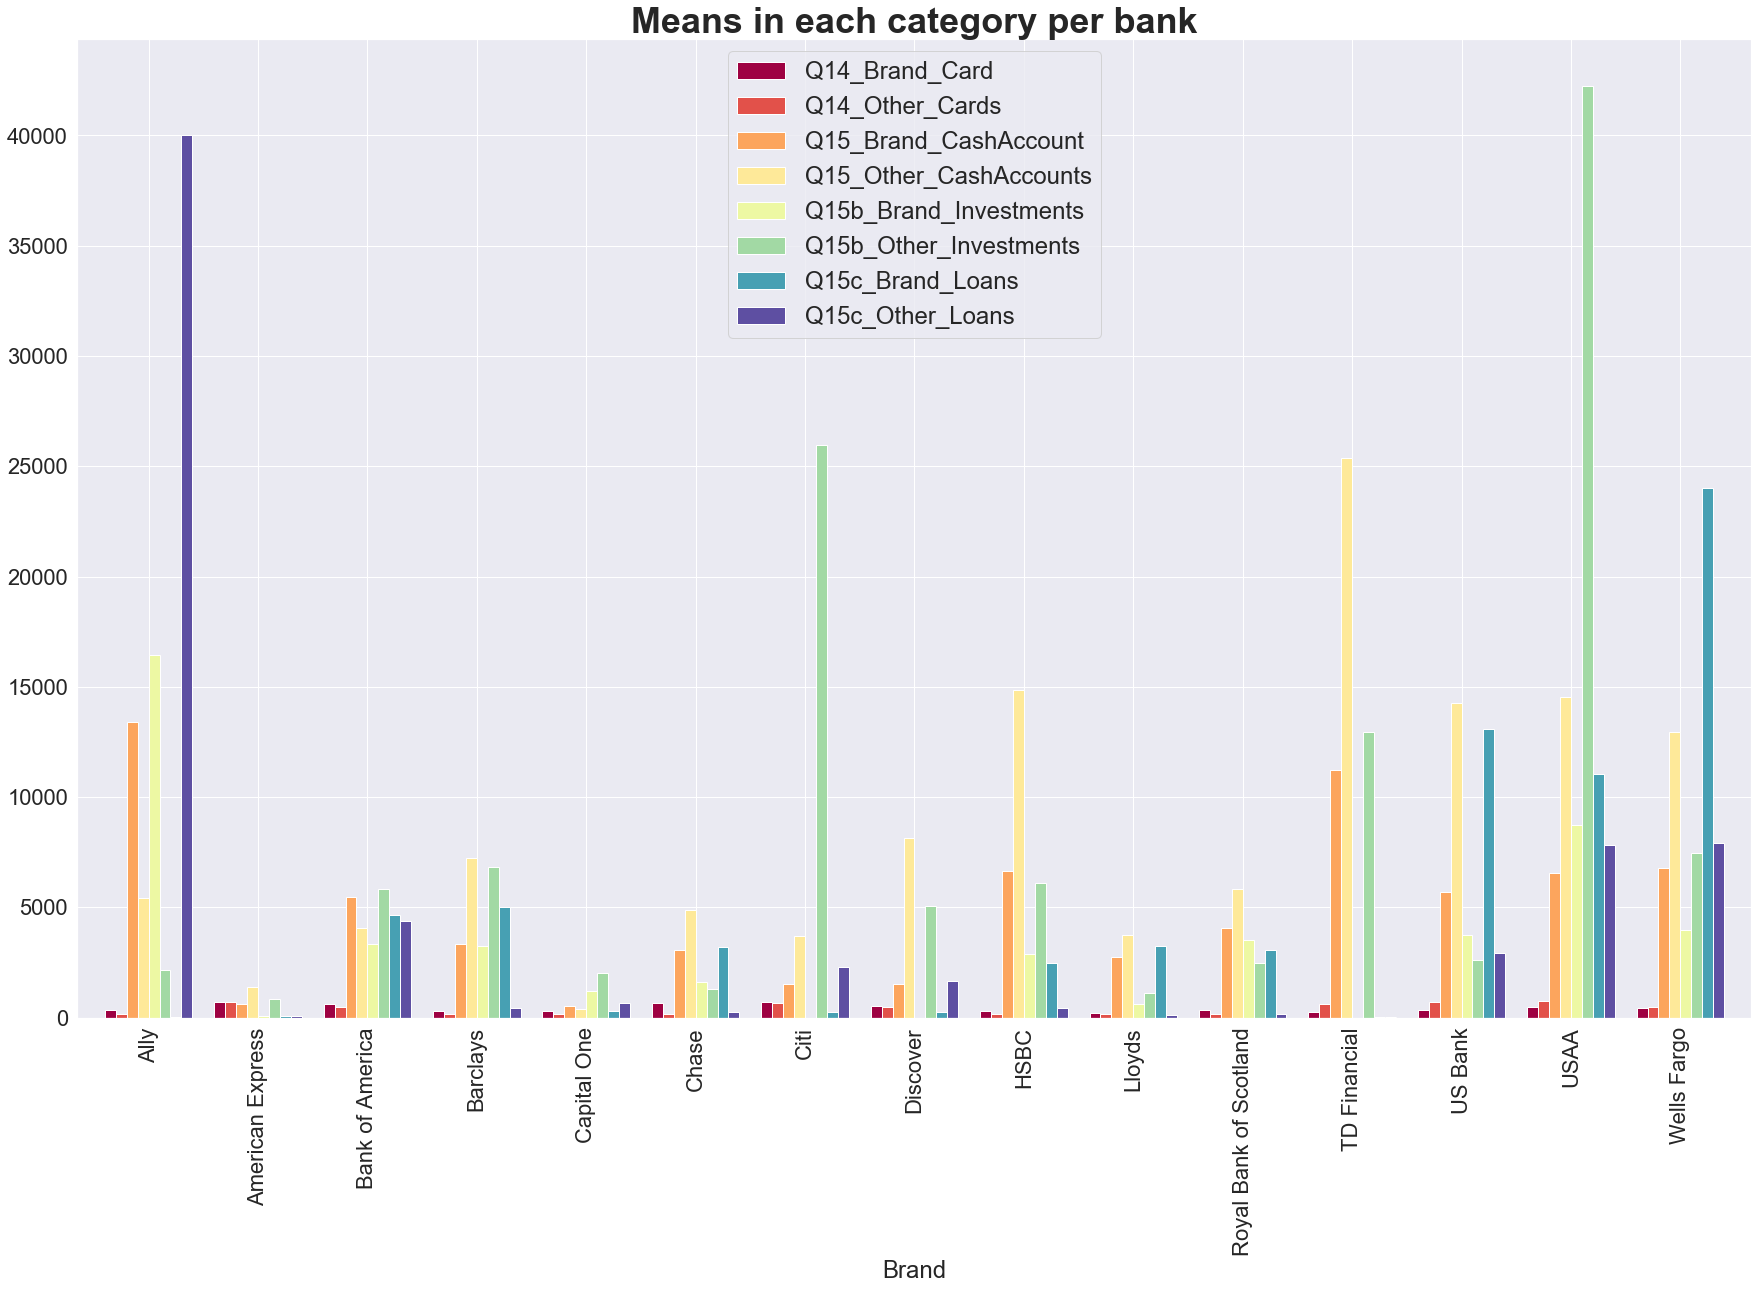

In [42]:
cred.groupby('Brand').mean().loc[:, 'Q14_Brand_Card':'Q15c_Other_Loans'].plot.bar(width=0.8, figsize = (30,18), cmap = 'Spectral')
plt.legend(prop={'size': 24})
plt.title('Means in each category per bank', size = 36, weight = 'bold')

#Only show if n>30, USAA result is odd

In [43]:
cred[cred['Brand']=='USAA']['Q15b_Other_Investments'].unique()

array([0.000e+00, 1.960e+04, 6.000e+04, 1.500e+04, 2.000e+05, 7.000e+05,
       4.250e+05, 1.500e+06, 1.000e+04, 1.000e+06, 7.000e+04, 1.000e+03,
       6.000e+03, 8.000e+05, 2.800e+05, 5.000e+00, 5.000e+01, 5.555e+03,
       3.000e+00])

In [44]:
import statsmodels.api as sm

amex = cred[(cred['Brand']=='Lloyds')]
X = amex[['Website', 'Loyalty prog', 'in-person retail branches','Credit card rewards earning', 'Benefits, Perks', 'Product']]
y = amex['Q14_Brand_Card']
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary(title = 'Lloyds OLS')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       Lloyds OLS                                      
=======================================================================================
Dep. Variable:         Q14_Brand_Card   R-squared (uncentered):                   0.284
Model:                            OLS   Adj. R-squared (uncentered):              0.259
Method:                 Least Squares   F-statistic:                              11.36
Date:                Tue, 19 May 2020   Prob (F-statistic):                    1.12e-10
Time:                        20:39:26   Log-Likelihood:                         -1311.2
No. Observations:                 178   AIC:                                      2634.
Df Residuals:                     172   BIC:                                      2653.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Website                         5.7552     11.148      0.516      0.606     -16.249      27.759
Loyalty prog                    6.4256     18.012      0.357      0.722     -29.128      41.979
in-person retail branches     -27.5978     14.474     -1.907      0.058     -56.168       0.972
Credit card rewards earning    41.5782     16.434      2.530      0.012       9.139      74.017
Benefits, Perks                 1.9565     18.619      0.105      0.916     -34.794      38.707
Product                        30.4546     16.630      1.831      0.069      -2.371      63.280
==============================================================================
Omnibus:                      194.953   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5600.765
Skew:                           4.259   Prob(JB):                         0.00
Kurtosis:                      29.127   Cond. No.                         7.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

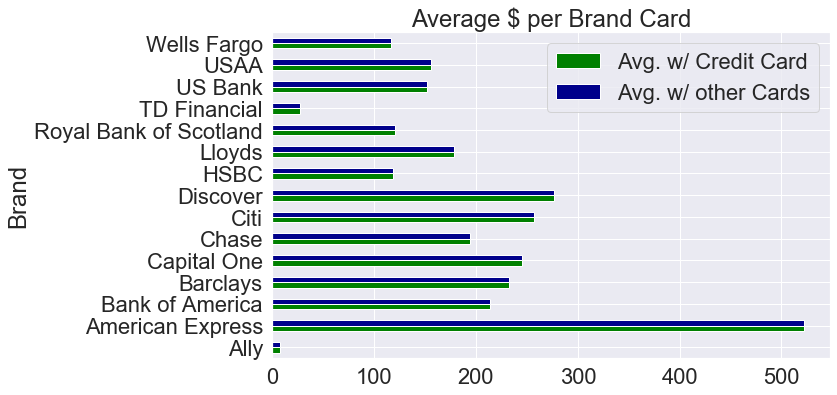

In [45]:
#AVERAGE $ IN CREDIT CARD PER BRAND

brand_c = cred.groupby('Brand').count().loc[:, 'Q14_Brand_Card':'Q14_Other_Cards'] 
brand_c = brand_c.rename(columns = {'Q14_Brand_Card':'Avg. w/ Credit Card',
                                   'Q14_Other_Cards':'Avg. w/ other Cards'})
#brand_c['Avg. w/o Credit Card']= no_cred.groupby('Brand').mean().loc[:, 'Q14_Brand_Card':'Q14_Brand_Card']
brand_c.plot.barh(color = ['green','darkblue'], figsize = (10,6), 
                  title = 'Average $ per Brand Card')

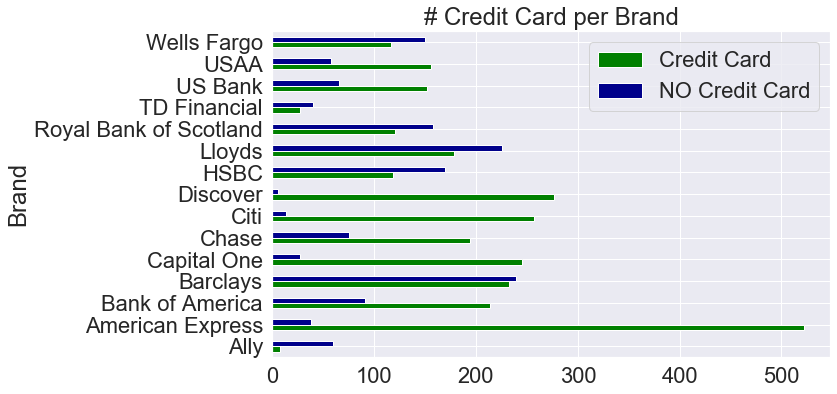

In [46]:
#OWNERSHIP OF A CREDIT CARD PER BRAND

perbrand_c = cred.groupby('Brand').count().loc[:, 'Q14_Brand_Card':'Q14_Brand_Card'] 
perbrand_c = perbrand_c.rename(columns = {'Q14_Brand_Card':'Credit Card'})
perbrand_c['NO Credit Card'] = no_cred.groupby('Brand').count().loc[:, 'Q14_Brand_Card':'Q14_Brand_Card'] 
perbrand_c.plot.barh(color = ['green','darkblue'], figsize = (10,6), 
                  title = '# Credit Card per Brand')

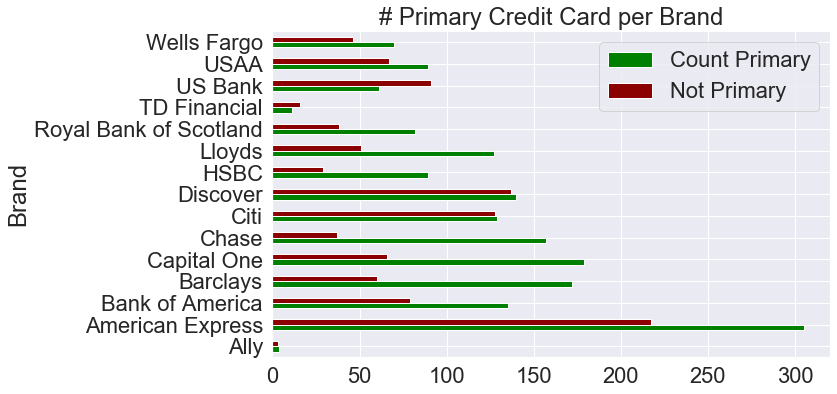

In [47]:
#PRIMARY STATUS OF BRAND

primary = cred[(cred['CC Primary'] == 1) | (cred['CC Primary'] == 3)].groupby('Brand').count().loc[:, 'Age':'Age'] 
not_primary = cred[(cred['CC Primary'] == 2) | (cred['CC Primary'] == 4)].groupby('Brand').count().loc[:, 'Age':'Age'] 
primary = primary.rename(columns = {'Age':'Count Primary'})
not_primary = not_primary.rename(columns = {'Age':'Count Primary'})

CCprim = primary
CCprim = CCprim.rename(columns = {'Age':'Primary'})
CCprim['Not Primary'] = not_primary
CCprim.plot.barh(color = ['green','darkred'], figsize = (10,6), 
                  title = '# Primary Credit Card per Brand')

In [48]:
#CREDIT & DEBIT Owners VS. none of both

cre_deb = bank[(bank['Own_CreditC']==1) | (bank['Own_DebitC']==1)]
no_cre_deb = bank[(bank['Own_CreditC']!=1) & (bank['Own_DebitC']!=1)]
no_cre_deb.describe(percentiles = (0.5, 0.75, 0.9)).loc[['count','mean', '50%', '75%', '90%', 'max']]

,weights,Age,A_bucket,Gender,S3_US_States,Repurchase Likelihood,Willingness to Recommend,Likelihood to try new,Own_Checking,Own_Savings,...,Driver_Price,Driver_Product/Service Quality,Driver_Data & Security,Driver_Self-Expression,Driver_Social Proof,Driver_Social Responsibility,Driver_Trust/Authenticity,Driver_Value,Driver_Information,Driver_Category Impact
count,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,...,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000
mean,1.088275,47.681034,5.670259,1.607759,-20.262931,6.086207,6.426724,4.390086,0.403017,0.338362,...,4.896552,4.689655,4.753233,4.162716,4.113147,4.331897,4.640086,4.696121,4.269397,4.482759
50%,0.794263,49.000000,6.000000,2.000000,9.500000,6.000000,7.000000,4.000000,0.000000,0.000000,...,5.000000,4.500000,5.000000,4.000000,4.000000,4.000000,4.500000,4.500000,4.000000,4.000000
75%,1.130445,62.000000,7.000000,2.000000,31.000000,7.000000,9.000000,5.000000,1.000000,1.000000,...,6.000000,6.000000,6.000000,5.500000,5.000000,5.500000,6.000000,6.000000,5.000000,6.000000
90%,1.982144,68.000000,8.000000,2.000000,39.000000,8.000000,10.000000,6.000000,1.000000,1.000000,...,7.000000,7.000000,6.500000,6.500000,6.500000,6.500000,7.000000,7.000000,7.000000,7.000000
max,5.797803,74.000000,8.000000,2.000000,50.000000,9.000000,10.000000,7.000000,1.000000,1.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


##  Correlations

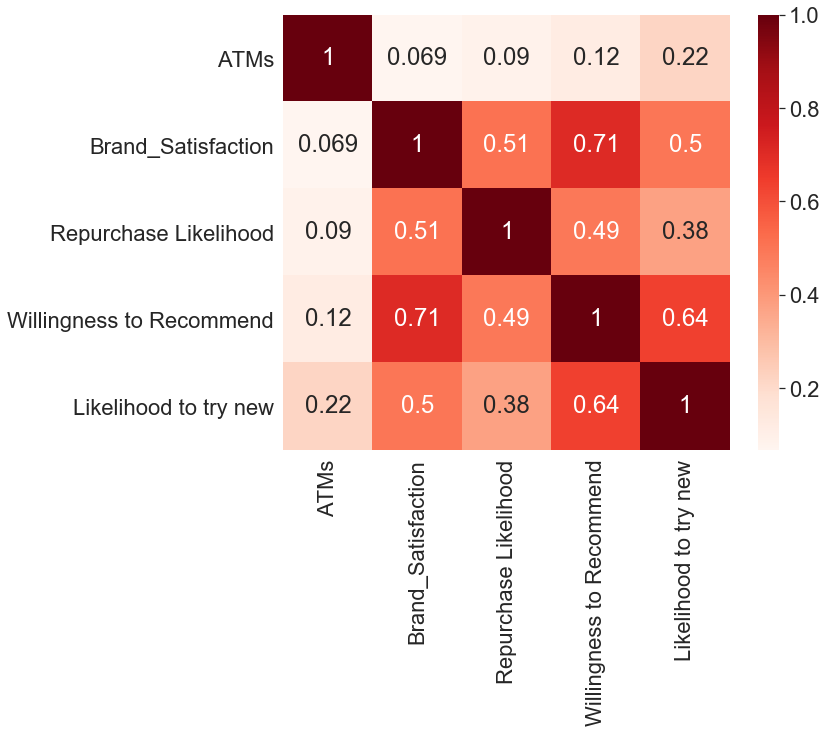

In [49]:
#GENERAL Corr

test = cred[['ATMs','Brand_Satisfaction', 'Repurchase Likelihood', 'Willingness to Recommend', 'Likelihood to try new']]
plt.figure(figsize=(10,8))
cor = test.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

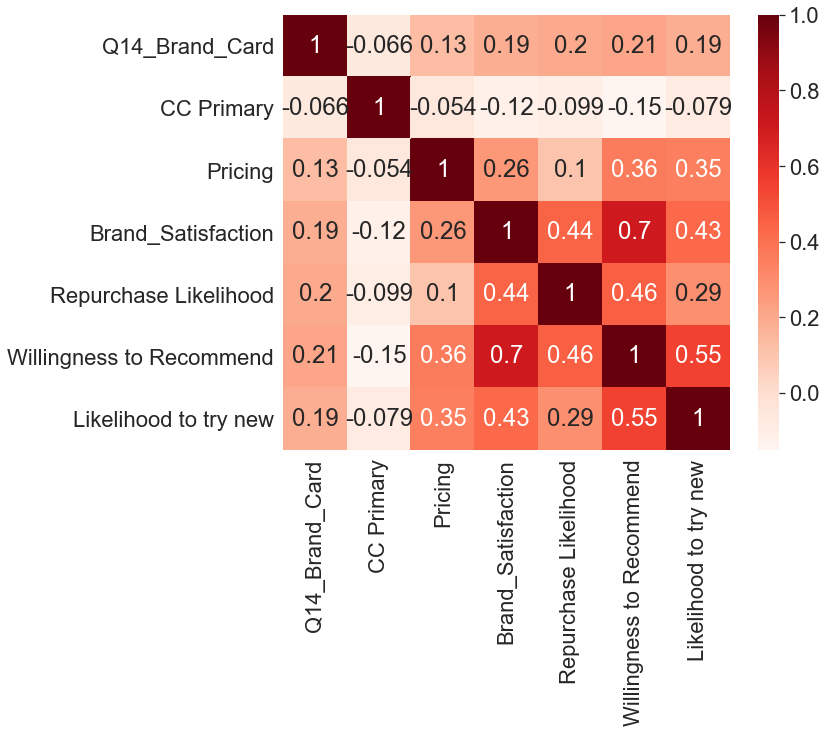

In [50]:
#AMEX Corr

bnq = cred[cred['Brand'] == 'American Express']
test = bnq[['Q14_Brand_Card','CC Primary', 'Pricing', 'Brand_Satisfaction', 
            'Repurchase Likelihood', 'Willingness to Recommend', 'Likelihood to try new']]
plt.figure(figsize=(10,8))
cor = test.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Linear Regression

In [51]:
def model_preparation(data):
    X = data['Mobile_app']
    X = np.asarray(X).astype(int).reshape(-1, 1)
    Y = data['Live_Chat'].astype(int)
    Y = Y.to_numpy().reshape(len(Y),)
    
    return X, Y

X, y = model_preparation(bank)
sample_weight = bank['weights']

In [52]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y,sample_weight=sample_weight)
from regressors import stats

print("coef_pval:\n", stats.coef_pval(reg, X, y))  
stats.summary(reg, X, y)

coef_pval:
 [0. 0.]
Residuals:
    Min      1Q  Median      3Q    Max
 0.5129  0.5129  0.5129  3.0416  3.463


Coefficients:
            Estimate  Std. Error  t value  p value
_intercept  0.512934    0.046921  10.9318      0.0
x1          0.421439    0.009208  45.7710      0.0
---
R-squared:  0.17602,    Adjusted R-squared:  0.17582
F-statistic: 902.53 on 1 features


<h2> Clustering / Segmentation </h2>

Text(0.5, 1.0, 'Means in each category per bank')

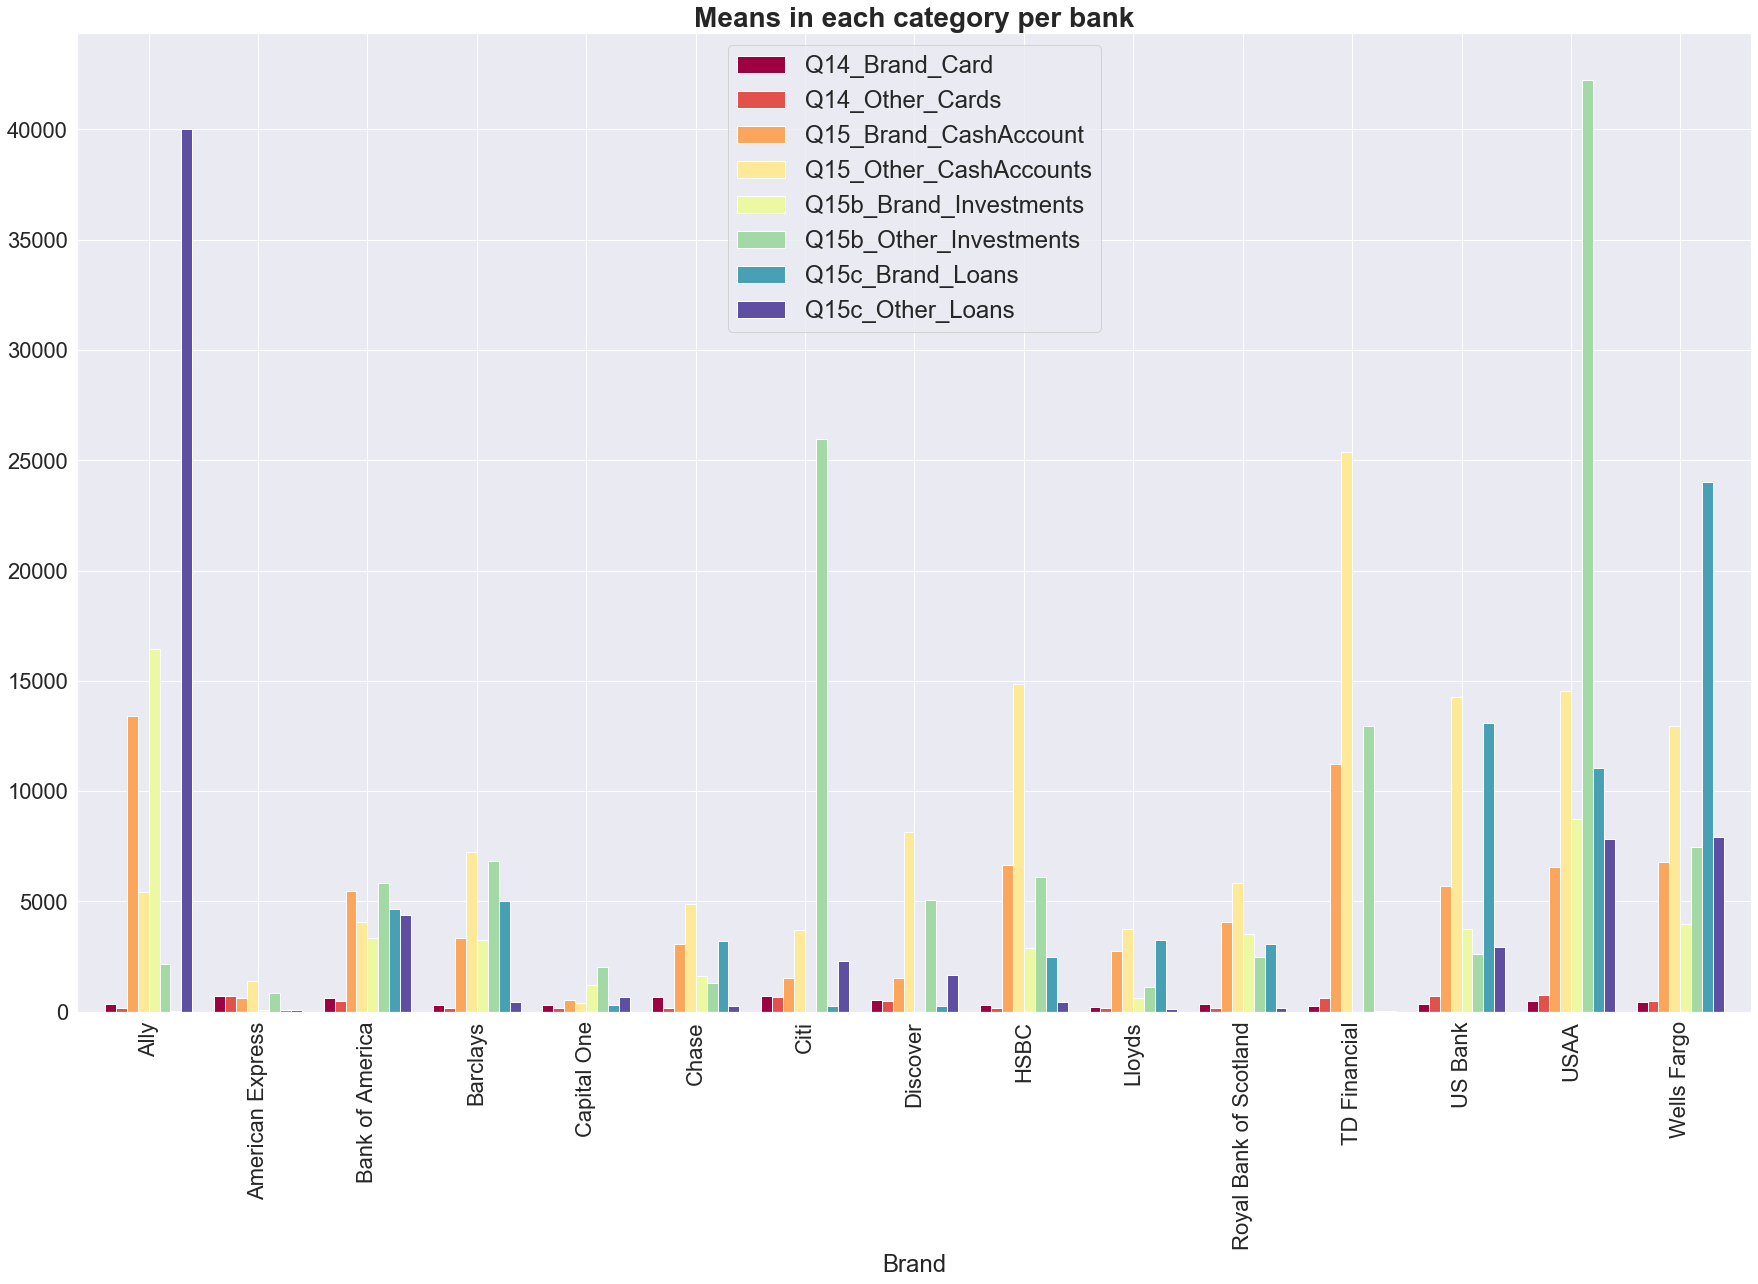

In [53]:
cred.groupby('Brand').mean().loc[:, 'Q14_Brand_Card':'Q15c_Other_Loans'].plot.bar(width=0.8, figsize = (30,18), cmap = 'Spectral')
plt.legend(prop={'size': 24})
plt.title('Means in each category per bank', size = 28, weight = 'bold')

#Only show if n>30, USAA result is odd

In [54]:
#USE THIS TO PICK THE # FACTORS TO BE ANALYZED IN CLUSTERING/SEGMENTATION

sett = cred[cred['Brand']=='USAA'][['Q15b_Other_Investments', 'Age', 'Attr_Inspiration']].copy()
sett = sett.fillna(0)
sett.head()

,Q15b_Other_Investments,Age,Attr_Inspiration
5472,0.0,57,4
6958,0.0,36,7
7522,0.0,47,7
8237,0.0,33,7
8849,0.0,49,5


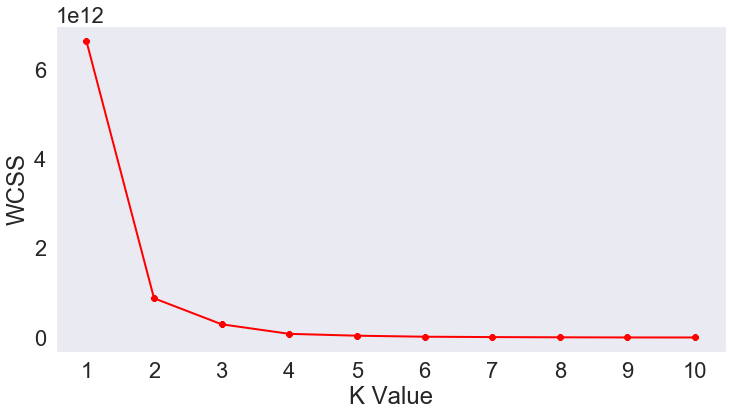

In [55]:
from sklearn.cluster import KMeans
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(sett.iloc[:,0:3])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

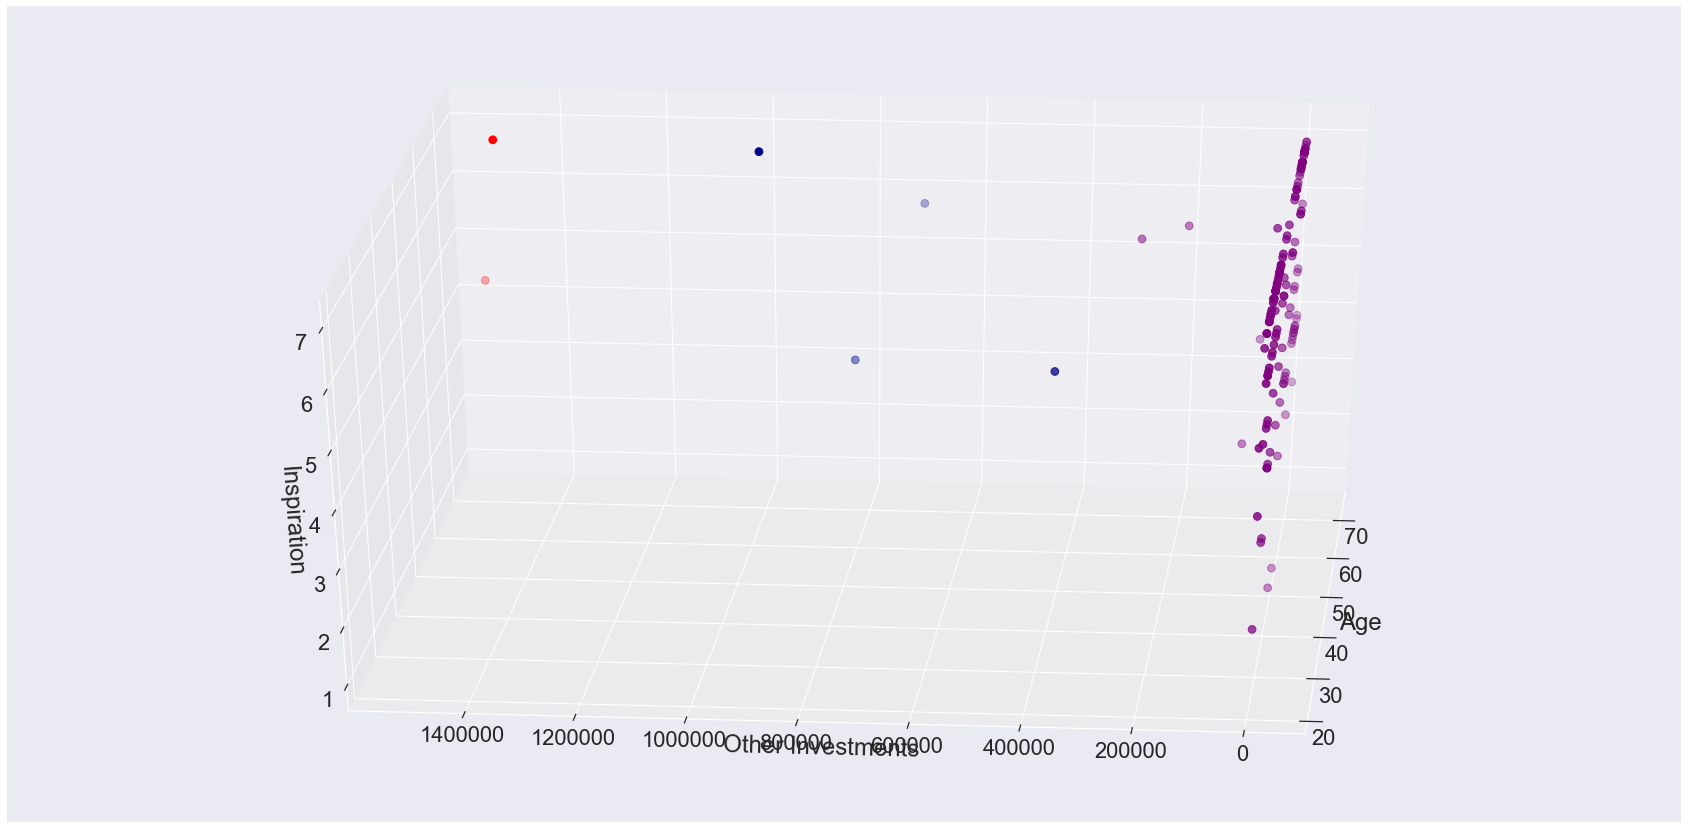

In [58]:
#Q72/73 sentiment level, in banking

km = KMeans(n_clusters=3)
clusters = km.fit_predict(sett.iloc[:,0:])
sett["label"] = clusters

from mpl_toolkits.mplot3d import Axes3D
 
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sett.Age[sett.label == 0], sett['Q15b_Other_Investments'][sett.label == 0], sett['Attr_Inspiration'][sett.label == 0], c='purple', s=60)
ax.scatter(sett.Age[sett.label == 1], sett['Q15b_Other_Investments'][sett.label == 1], sett['Attr_Inspiration'][sett.label == 1], c='red', s=60)
ax.scatter(sett.Age[sett.label == 2], sett['Q15b_Other_Investments'][sett.label == 2], sett['Attr_Inspiration'][sett.label == 2], c='darkblue', s=60)

#Uncomment if you want to use more clusters

#ax.scatter(sett.Age[sett.label == 3], sett['Q10'][sett.label == 3], sett['Brand_Satisfaction'][sett.label == 3], c='purple', s=60)
#ax.scatter(sett.Age[sett.label == 4], sett['Mobile_app'][sett.label == 4], sett['Pricing'][sett.label == 4], c='purple', s=60)

ax.view_init(30, 185)
plt.xlabel('Age')

plt.ylabel('Other Investments')
ax.set_zlabel('Inspiration')
plt.show()

In [59]:
cred[(cred['Brand'] == 'USAA') & (cred['Q15b_Other_Investments'] >= 1000000)]

,Programming_Category,Brand,weights,Age,A_bucket,Gender,S3_US_States,Repurchase Likelihood,Willingness to Recommend,Likelihood to try new,...,Driver_Price,Driver_Product/Service Quality,Driver_Data & Security,Driver_Self-Expression,Driver_Social Proof,Driver_Social Responsibility,Driver_Trust/Authenticity,Driver_Value,Driver_Information,Driver_Category Impact
51013,Banking & Credit Cards,USAA,0.548427,63,7,2,25,8,7,4,...,5,4.5,4.5,4.0,4.0,4.5,5.0,5.0,5,4
55778,Banking & Credit Cards,USAA,0.617546,68,8,1,34,8,10,5,...,7,7.0,7.0,5.5,4.0,7.0,7.0,7.0,4,5
88344,Banking & Credit Cards,USAA,0.617546,70,8,1,5,8,10,5,...,6,6.0,6.0,5.0,4.0,6.0,6.0,6.0,5,4


<h2> Customer Engagement vs Brand Satisfaction </h2>

In [72]:
# Feature Engineering for Q72
def feature_engineering_Q72(df): 
    df['Attr_Advocacy'] = (df['Q72_1'] + df['Q72_2'] + df['Q72_3'])/3
    df['Attr_Choice'] = df['Q72_4']
    df['Attr_Distress_if_discontinued'] = df['Q72_5']
    df['Attr_Invested in brand success'] = (df['Q72_6'] + df['Q72_7'])/2
    df['Attr_Self_connected'] = df['Q72_8']
    df['Attr_Self_expression'] = df['Q72_9']
    df['Attr_Trust'] = (df['Q72_10'] + df['Q72_11'])/2
    df['Attr_Choice'] = df['Q72_12']
    df['Attr_Expectation'] = df['Q72_13']
    df['Attr_Inspiration'] = df['Q72_14']
    df['Attr_Magic & Transformation'] = df['Q72_15']
    df['Attr_Social & responsibility'] = df['Q72_16']
    df['Attr_Utilitarian'] = df['Q72_17']
    df['Attr_Values alignment'] = df['Q72_18']
    df['Attr_Enjoyment'] = df['Q72_19']
    df['Attr_Pride'] = df['Q72_20']
    
    return df

In [73]:
def customer_engagement_driver(df,high,low,neutral,outcome):
    df = data[['weights',outcome] + list(data.loc[:,'Q73_1':'Q73_40'])].set_index(['weights'])
    df = df[df[outcome] != ' ']
    df.loc[:,'Q73_1':'Q73_40'] = df.loc[:,'Q73_1':'Q73_40'].replace(' ', np.nan)
    df = df.apply(pd.to_numeric)
    df = df[(df['Q73_40']==2)]#  filter with the straight liner test
    
    df = df[(df[outcome]!=neutral)] 
    df.loc[df[outcome]>=high, 'Satisfaction_tier'] = 1
    df.loc[df[outcome]<=low, 'Satisfaction_tier'] = 0
    df = df.drop(columns=[outcome])
    df.reset_index(inplace=True)
    
    imputer = KNNImputer(n_neighbors=2)  # This could be one parameters to select
    df.loc[:,"Q73_1":"Q73_40"] = imputer.fit_transform(df.loc[:,"Q73_1":"Q73_40"])
    df = feature_engineering_Q73(df)
    df.reset_index(inplace=True)
    
    return df

In [74]:
# Feature Engineering for Q73
def feature_engineering_Q73(df):
    df['Driver_Accessibility'] = (df['Q73_1'] + df['Q73_2'] + df['Q73_3'] + df['Q73_4'])/4
    df['Driver_Consistency'] = (df['Q73_5'] + df['Q73_6'] + df['Q73_7'])/3
    df['Driver_Ease of use'] = df['Q73_8']
    df['Driver_Empathy'] = (df['Q73_9'] + df['Q73_10'] + df['Q73_11'])/3
    df['Driver_Latest & Greatest'] = (df['Q73_12'] + df['Q73_12'])/2
    df['Driver_Leadership'] = (df['Q73_14'] + df['Q73_15'])/2
    df['Driver_Memorable & Nostalgia'] = df['Q73_16']
    df['Driver_Personalization'] = (df['Q73_17'] + df['Q73_18'] + df['Q73_19'] 
                                    + df['Q73_20'] + df['Q73_21'] + df['Q73_22'])/6

    df['Driver_Price'] = df['Q73_23']
    df['Driver_Product/Service Quality'] = (df['Q73_24'] + df['Q73_25'])/2
    df['Driver_Data & Security'] = (df['Q73_26'] + df['Q73_27'])/2

    df['Driver_Self-Expression'] = (df['Q73_28'] + df['Q73_29'])/2
    df['Driver_Social Proof'] =(df['Q73_30'] + df['Q73_31'])/2
    df['Driver_Social Responsibility'] = (df['Q73_32'] + df['Q73_33'])/2
    df['Driver_Trust/Authenticity'] = (df['Q73_34'] + df['Q73_34'])/2
    df['Driver_Value'] = (df['Q73_36'] + df['Q73_36'])/2
    df['Driver_Information'] = df['Q73_38']
    df['Driver_Category Impact'] = df['Q73_39']
    
    df = df[['weights'] + list(df.loc[:,'Satisfaction_tier':'Driver_Category Impact'])].set_index(['weights'])
    return df

In [75]:
def customer_engagement_attribute(df,high,low,neutral,outcome):
    df = data[['weights',outcome] + list(data.loc[:,'Q72_1':'Q72_21'])].set_index(['weights'])
    df = df[df[outcome] != ' ']
    df.loc[:,'Q72_1':'Q72_21'] = df.loc[:,'Q72_1':'Q72_21'].replace(' ', np.nan)
    df = df.apply(pd.to_numeric)
    df = df[(df['Q72_21']==2)]#  filter with the straight liner test
    
    df = df[(df[outcome]!=neutral)] 
    df.loc[df[outcome]>=high, 'Satisfaction_tier'] = 1
    df.loc[df[outcome]<=low, 'Satisfaction_tier'] = 0
    df = df.drop(columns=[outcome])
    df.reset_index(inplace=True)
    
    imputer = KNNImputer(n_neighbors=2)  # This could be one parameters to select
    df.loc[:,"Q72_1":"Q72_20"] = imputer.fit_transform(df.loc[:,"Q72_1":"Q72_20"])
    df = feature_engineering_Q72(df)
    
    return df

<h4> Brand Satisfaction vs Customer Engagement Attribute </h4>

In [77]:
dfx = customer_engagement_attribute(bank,5,3,4,'Q67')
coef = bi_logistic(dfx,'Attr_Advocacy','Attr_Pride')
coef

,Features,Coefficient
7,Attr_Expectation,0.573355
6,Attr_Trust,0.516790
11,Attr_Utilitarian,0.390988
1,Attr_Choice,0.377596
0,Attr_Advocacy,0.320346
2,Attr_Distress_if_discontinued,0.137208
12,Attr_Values alignment,0.077504
14,Attr_Pride,0.069077
13,Attr_Enjoyment,0.037250
9,Attr_Magic & Transformation,0.021696


<h4> Brand Satisfaction vs Customer Engagement Driver </h4>

In [78]:
dfx = customer_engagement_driver(bank,5,3,4,'Q67')
coef = bi_logistic(dfx,'Driver_Accessibility','Driver_Category Impact')
coef

,Features,Coefficient
1,Driver_Consistency,1.119265
9,Driver_Product/Service Quality,0.393423
0,Driver_Accessibility,0.251234
3,Driver_Empathy,0.188481
2,Driver_Ease of use,0.175014
5,Driver_Leadership,0.173949
14,Driver_Trust/Authenticity,0.172029
8,Driver_Price,0.118086
15,Driver_Value,0.101639
12,Driver_Social Proof,0.015829
